# 📊 A Data-Driven Model for Predicting ART Adherence Among Kenyan Adolescents

## 🧠 Project Background

Antiretroviral Therapy (ART) adherence is critical in managing HIV, especially among adolescents in Kenya. However, adherence levels can vary significantly due to a complex interplay of medical, psychosocial, and demographic factors.

This project seeks to develop a predictive machine learning model that identifies whether a Kenyan adolescent living with HIV is likely to be adherent or non-adherent to their ART regimen. The study uses a **synthetic dataset**, designed to reflect real-world complexities based on clinical patterns, public datasets, and domain knowledge from healthcare practice in Kenya.

By combining clinical reasoning with machine learning techniques, the model aims to support clinicians and outreach teams in early identification of at-risk adolescents, allowing for targeted interventions.

---

## 🎯 Project Objectives

### 🔹 General Objective
To build a robust, interpretable machine learning model that predicts ART adherence among adolescents in Kenya using clinical, demographic, and behavioral features.

### 🔸 Specific Objectives
1. To generate a synthetic dataset simulating Kenyan adolescent ART patients based on key clinical and social determinants.
2. To perform exploratory data analysis (EDA) and identify key patterns affecting ART adherence.
3. To preprocess the dataset through missing value treatment, outlier handling, feature encoding, and scaling.
4. To train multiple machine learning models and select the best-performing one based on recall, especially for the **non-adherent** class.
5. To build a GUI using **Streamlit** for model deployment, with interpretation features for clinical use.
6. To evaluate model interpretability and reliability using real-world-inspired scenarios and feature importance analysis.

---

## 🧪 This Notebook Covers:
- Library setup and environment initialization
- Data generation, cleaning, and exploratory analysis
- Feature selection, model training, evaluation
- Final deployment and interpretability explanation using Streamlit

Let’s begin by setting up the working environment for data analysis and modeling.


In [1]:
# ART Adherence Prediction for Kenyan Adolescents
# ======================================================
# This notebook implements the data-driven model described in the research proposal
# to predict antiretroviral therapy (ART) adherence among Kenyan adolescents with HIV
# 1. Import essential libraries
# Data manipulation libraries
import pandas as pd
import numpy as np
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Statistical analysis
from scipy import stats
!pip install mysql-connector-python
# Machine learning libraries - as specified in proposal
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
# Models mentioned in proposal
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Note: We'll use gradient boosting from sklearn instead of XGBoost
from sklearn.ensemble import GradientBoostingClassifier
# Evaluation metrics
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_auc_score, precision_recall_curve,
                            roc_curve, auc)
# For handling imbalanced data (SMOTE) as mentioned in proposal
from imblearn.over_sampling import SMOTE
# Database connection for XAMPP/MySQL as specified in proposal
import mysql.connector
# Check if all packages are available
try:
    # Test one import from each major library
    pd.DataFrame()
    np.array([])
    plt.figure()
    sns.set()
    stats.norm()
    mysql.connector
    print("All required libraries successfully imported!")
except Exception as e:
    print(f"Error importing libraries: {e}")
    print("Please install missing packages before proceeding.")
# Set visualization defaults
plt.style.use('default')
sns.set()
print("Setup complete! proceeding  with data generation and analysis.")

All required libraries successfully imported!
Setup complete! proceeding  with data generation and analysis.


<Figure size 640x480 with 0 Axes>

# 🏗️ Step 1: Synthetic Dataset Generation for ART Adherence

To simulate real-world patterns in ART adherence among Kenyan adolescents, we created a **synthetic dataset** of **10,000 records**. This data mimics clinical, demographic, and behavioral factors commonly observed in HIV care settings in Kenya.

---

### 👨‍👩‍👧‍👦 1. Demographic Features
We generated patient attributes such as:
- **Age (10–19 years)**: Reflecting the adolescent bracket.
- **Gender**, **Education level**, and **Socioeconomic status**: Randomly sampled based on realistic distributions.
- **Urban vs. Rural** residence: 60% urban to reflect access variation.

---

### 🧬 2. Clinical Features
Key clinical indicators include:
- **CD4 Count** and **Viral Load**: Simulated using normal and log-normal distributions respectively.
- **Side Effects**, **Treatment Duration**, **Drug Regimen**, and **Comorbidities**: Modeled using domain-based probabilities.

---

### 🌍 3. Social and Environmental Features
These include:
- **Family Support**, **Peer Support**, and **Stigma Experience**
- **Distance to Clinic**: Generated using a beta distribution and adjusted higher for rural patients.

---

### 📉 4. Adherence Risk Simulation
Using a custom scoring function, we calculated each patient’s **adherence risk**:
- Risk increases with high viral load, low CD4 count, rural setting, being male, older age, and lack of HIV awareness.
- This score was used to probabilistically assign each patient as **Adherent (1)** or **Non-Adherent (0)**.

---

### ⚙️ 5. Feature Engineering for Analysis
To enrich the data for future exploration and modeling:
- **Age groups**: Categorized into 10–13, 14–16, and 17–19.
- **Support × Awareness interaction**: Highlights combined influence of support and knowledge.
- **Location-adjusted clinic distance**: Higher burden for rural areas.
- **Treatment complexity score**: Based on side effects and line of therapy.
- **Viral suppression status**: Derived from viral load + adherence behavior.

---

### ⚠️ 6. Real-World Challenges Simulated
- **Missing values** were introduced in 10% of key numeric and 5% of selected categorical features.
- **Outliers** were injected in viral load and travel distances to reflect real clinical data inconsistencies.

---

### 💾 Output
✅ Dataset successfully generated and saved as `'art_adherence_data.csv'` with **10,000 records**.

> This dataset will be the foundation for our exploratory analysis, model training, and clinical interpretation in the next steps.


In [4]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Define the number of records (10,000 as stated in my proposal)
n_samples = 10000

print("Generating synthetic ART adherence data for Kenyan adolescents...")

# ======= DEMOGRAPHIC FEATURES =======
print("Generating demographic features...")
age = np.random.randint(10, 20, n_samples)  # Age between 10-19 years
gender = np.random.choice(['Male', 'Female'], n_samples)
location = np.random.choice(['Urban', 'Rural'], n_samples, p=[0.6, 0.4])  # 60% urban, 40% rural
education_level = np.random.choice(['Primary', 'Secondary', 'Tertiary'], n_samples, p=[0.5, 0.4, 0.1])
socioeconomic_status = np.random.choice(['Low', 'Medium', 'High'], n_samples, p=[0.5, 0.3, 0.2])

# ======= CLINICAL FEATURES =======
print("Generating clinical features...")
cd4_count = np.clip(np.random.normal(500, 200, n_samples), 50, 1200)
viral_load = np.clip(np.exp(np.random.normal(6, 1.5, n_samples)), 20, 100000)
treatment_duration = np.clip(np.random.gamma(shape=2, scale=10, size=n_samples), 1, 60)
side_effects = np.random.choice(['None', 'Mild', 'Severe'], n_samples, p=[0.6, 0.3, 0.1])
comorbidities = np.random.choice(['None', 'One', 'Multiple'], n_samples, p=[0.7, 0.2, 0.1])
drug_regimen = np.random.choice(['First-line', 'Second-line', 'Third-line'], n_samples, p=[0.7, 0.2, 0.1])

# ======= SOCIAL AND ENVIRONMENTAL FEATURES =======
print("Generating social and environmental features...")
family_support = np.random.choice(['Low', 'Medium', 'High'], n_samples, p=[0.3, 0.4, 0.3])
distance_to_clinic = np.random.beta(2, 5, n_samples) * 50
awareness_status = np.random.choice([0, 1], n_samples, p=[0.3, 0.7])  # 70% are aware of their status
stigma_experience = np.random.choice(['Low', 'Medium', 'High'], n_samples, p=[0.4, 0.4, 0.2])
peer_support = np.random.choice([0, 1], n_samples, p=[0.6, 0.4])

# Create the base dataframe
data = pd.DataFrame({
    'Age': age,
    'Gender': gender,
    'Location': location,
    'Education_Level': education_level,
    'Socioeconomic_Status': socioeconomic_status,
    'CD4_Count': cd4_count.astype(int),
    'Viral_Load': viral_load.astype(int),
    'Treatment_Duration': treatment_duration.astype(int),
    'Side_Effects': side_effects,
    'Comorbidities': comorbidities,
    'Drug_Regimen': drug_regimen,
    'Family_Support': family_support,
    'Distance_to_Clinic': distance_to_clinic,
    'Awareness_Status': awareness_status,
    'Stigma_Experience': stigma_experience,
    'Peer_Support': peer_support
})
# ======= ADHERENCE RISK CALCULATION =======
print("Calculating adherence risk...")

def calculate_adherence_risk(row):
    risk = 0.2  # Base risk (starting point for all patients)
    
    # Increase risk if the patient is unaware of their HIV status
    if row['Awareness_Status'] == 0:
        risk += 0.50
    
    # Additional risk factors
    if row['Age'] >= 17:
        risk += 0.08
    if row['Gender'] == 'Male':
        risk += 0.04
    if row['Location'] == 'Rural':
        risk += 0.05
    if row['CD4_Count'] < 200:
        risk += 0.10
    if row['Viral_Load'] > 10000:
        risk += 0.08
    if row['Side_Effects'] == 'Severe':
        risk += 0.15
    
    return max(0, min(risk, 0.95))  # Ensure risk stays between 0 and 95%

# Calculate adherence risk for each patient
data['Adherence_Risk'] = data.apply(calculate_adherence_risk, axis=1)

# ======= INTRODUCING MISSING VALUES =======
print("Introducing missing values...")
for col in ['CD4_Count', 'Viral_Load', 'Distance_to_Clinic']:
    data.loc[data.sample(frac=0.1).index, col] = np.nan  # 10% missing in numeric features
for col in ['Education_Level', 'Side_Effects']:
    data.loc[data.sample(frac=0.05).index, col] = np.nan  # 5% missing in categorical features

# ======= INTRODUCING OUTLIERS =======
print("Introducing outliers...")
outlier_indices = np.random.choice(data.index, size=10, replace=False)  # Select 10 random rows for outliers
data.loc[outlier_indices[:5], 'Viral_Load'] = [150000, 200000, 180000, 220000, 250000]  # Extreme values
data.loc[outlier_indices[5:], 'Distance_to_Clinic'] = [100, 120, 110, 130, 150]  # Unrealistic travel distances


# ======= ADHERENCE STATUS GENERATION =======
print("Generating adherence status...")

# Based on adherence risk, create adherence status: 0 = Non-adherent, 1 = Adherent
data['Adherence_Status'] = data.apply(
    lambda row: np.random.choice([0, 1], p=[1 - row['Adherence_Risk'], row['Adherence_Risk']]),
    axis=1
)  

# ======= FEATURE ENGINEERING =======
print("Creating new engineered features for better EDA...")

# Categorizes age into three groups (10-13, 14-16, 17-19) to analyze adherence differences.
data['Age_Group'] = pd.cut(data['Age'], bins=[9, 13, 16, 19], labels=['10-13', '14-16', '17-19'])

# Creates a binary feature (1 or 0) indicating if a patient has high family support and knows their HIV status.
data['Support_Awareness_Interaction'] = ((data['Family_Support'] == 'High') & (data['Awareness_Status'] == 1)).astype(int)

# Adjusts travel burden by increasing the distance by 1.5x for rural patients to reflect real-world challenges.
data['Location_Distance_Interaction'] = data.apply(
    lambda row: row['Distance_to_Clinic'] * 1.5 if row['Location'] == 'Rural' else row['Distance_to_Clinic'],
    axis=1
)

# Convert viral load to categorical status ('Suppressed' if <1000, otherwise 'Unsuppressed').
# Adjust viral suppression status based on adherence status.
data['Viral_Suppression_Status'] = data.apply(
    lambda row: 'Suppressed' if row['Adherence_Status'] == 1 and row['Viral_Load'] < 1000 else 'Unsuppressed',
    axis=1
)
# Calculates treatment complexity based on drug regimen (higher lines are more complex) and side effects severity.
data['Treatment_Complexity_Score'] = data.apply(
    lambda row: (2 if row['Drug_Regimen'] == 'Third-line' else 1 if row['Drug_Regimen'] == 'Second-line' else 0) +
                (2 if row['Side_Effects'] == 'Severe' else 1 if row['Side_Effects'] == 'Mild' else 0),
    axis=1
)

# Drops the temporary adherence risk column since it was only used for generating adherence status.
data.drop('Adherence_Risk', axis=1, inplace=True)
# Save the dataset to a CSV file
data.to_csv(r'C:\Users\USER\Desktop\art_adherence_data.csv', index=False)
print("\nDataset saved to 'art_adherence_data.csv'")

print(f"Synthetic dataset created with {n_samples} records")

Generating synthetic ART adherence data for Kenyan adolescents...
Generating demographic features...
Generating clinical features...
Generating social and environmental features...
Calculating adherence risk...
Introducing missing values...
Introducing outliers...
Generating adherence status...
Creating new engineered features for better EDA...

Dataset saved to 'art_adherence_data.csv'
Synthetic dataset created with 10000 records


# Exploratory Data Analysis

This section explores the structure and insights of the synthetic ART adherence dataset, guiding predictive modeling with emphasis on understanding non-adherence among adolescents. We use visual interpretations and data summaries to explain how clinical, demographic, and psychosocial features influence adherence behavior.

---

## 3.1 Dataset Overview

- **Observations**: 10,000 adolescents  
- **Target variable**: `Adherence_Status` (binary: 1 = Adherent, 0 = Non-Adherent)  
- **Features**: A mix of clinical, geographic, and behavioral variables such as:
  - `Viral_Load`, `CD4_Count`, `Age`, `Awareness_Status`, `Distance_to_Clinic`, `Side_Effects`, and engineered scores

---

## 3.2 Missing Values  

📊 **Interpretation**:
- ~10% missing in numeric features: `CD4_Count`, `Viral_Load`, `Distance_to_Clinic`
- ~5% missing in categorical features: `Side_Effects`, `Education_Level`

✅ **Conclusion**:
- Apply **median imputation** for numerical skewed variables.
- Use **mode or custom flags** for categorical missingness.

---

## 3.3 Target Variable Distribution  

📊 **Interpretation**:
- `Adherence_Status = 1` (Adherent): 4,358 (44%)  
- `Adherence_Status = 0` (Non-Adherent): 5,64Research Objectives 
General Objective 
To develop and implement a data-driven model that predicts ART adherence patterns among 
Kenyan adolescents, identifies key influencing factors, and generates insights for 
personalized intervention strategies. 
Specific Objectives 
1. To generate synthetic healthcare data that accurately represents ART adherence patterns 
and associated factors among Kenyan adolescents. 
2. To develop a machine learning model for predicting adherence outcomes using 
demographic, clinical, and social-environmental factors. 
3. To implement a feature importance analysis system to identify and rank the impact of 
various factors on ART adherence prediction.2 (56%)

✅ **Conclusion**:
- The imbalance is **realistic**, not extreme.
- Model tuning will emphasize **recall on the non-adherent class**.

---

## 3.4 Numerical Feature Analysis

### 📍 Age

📊 **Interpretation**:
- Ranges from **10 to 19**, as expected for adolescents.
- Slightly more concentration in mid-adolescence (ages 14–16).
- Distribution is relatively uniform with a **slight skew toward older teens**.

✅ **Conclusion**:
- Retain for demographic relevance and potential **age-linked adherence behaviors** (e.g., transition to adult care, independence).

---

### 📍 Viral Load

📊 **Interpretation**:
- Highly **right-skewed**, with outliers exceeding **250,000 copies/mL**.
- Most values fall under **30,000**, with dense presence between 0–20,000.

✅ **Conclusion**:
- Apply **log transformation** to correct skew.
- Useful for detecting treatment failure or suppression success.

---

### 📍 CD4 Count

📊 **Interpretation**:
- Clustered between **400–800 cells/μL**, reflecting moderate to healthy immune function.
- Some outliers above 1,200 may reflect well-suppressed individuals.

✅ **Conclusion**:
- Retain untransformed.
- Strong clinical indicator of ART effect.

---

### 📍 Treatment Complexity Score

📊 **Interpretation**:
- Most adolescents score **0–2**, indicating low regimen complexity and tolerable side effects.
- Scores **3–4** (rare) may reflect third-line regimens and severe side effects.

✅ **Conclusion**:
- Retain for clinical insight.
- Flags **high-burden subgroups** that may require intervention.

---

### 📍 Distance to Clinic

📊 **Interpretation**:
- Most live **within 5–40 km**.
- Right-skewed with some adolescents traveling **over 140 km** to access care.

✅ **Conclusion**:
- Key measure of **structural barrier**.
- Outliers should be preserved, not capped, for modeling access inequalities.

---

### 📍 Location-Distance Interaction

📊 **Interpretation**:
- Integrates rural/urban distinction with travel burden.
- Outliers above **200** indicate extreme access difficulty for rural adolescents.

✅ **Conclusion**:
- Retain over raw distance due to **higher contextual relevance**.
- May substitute `Distance_to_Clinic` during feature selection if multicollinearity arises.

---

## 3.5 Feature Correlation Analysis

📊 **Highlights**:
- `Awareness_Status`: r = **-0.45** → higher awareness improves adherence.
- `Support_Awareness_Interaction`: r = 0.33 → support and awareness amplify each other.
- `Distance_to_Clinic` & `Location_Distance_Interaction`: r ≈ 0.93 → consider dropping one.
- `Age`: weak correlation, but **demographically important** for understanding behavior across maturity levels.

✅ **Conclusion**:
- Low multicollinearity overall.
- Features like `Age`, `Awareness`, and interaction terms carry practical modeling value beyond correlation.

---

## 3.6 Viral Load by Adherence Group

📊 **Interpretation**:
- Non-adherent adolescents generally show higher viral loads.
- Some adherents still have high viral loads, which could reflect:
  - **Recent initiation**
  - **Delayed suppression**
  - **Drug resistance**

✅ **Conclusion**:
- Reinforces that adherence is **multi-factorial**.
- Enhances realism of the synthetic data — suppression isn't instant, even with adherence.

---

## 3.7 Statistical Tests for Categorical Variables

📊 **Chi-Square Results**:

✅ Significant:
- `Side_Effects` (p < 0.0001)  
- `Gender` (p < 0.0001)  
- `Location` (p = 0.0015)

❌ Not significant:
- `Education_Level`, `Comorbidities`, `Drug_Regimen`, `Family_Support`, `Stigma_Experience`, `Peer_Support`

✅ **Conclusion**:
- Behavioral and clinical features carry the most weight.
- Some non-significant variables may support interaction effects.

---

## 3.8 Random Forest Feature Importance

📊 **Top Features by RF Score**:
- `Viral_Suppression_Status_Unsuppressed`: 0.416  
- `Viral_Load`: 0.138  
- `Awareness_Status`: 0.123  
- Others: `CD4_Count`, `Distance_to_Clinic`, `Treatment_Duration`, `Side_Effects`, `Gender`, `Age`, `Treatment_Complexity_Score`

✅ **Conclusion**:
- Confirms dominance of **clinical and behavioral variables**.
- Even low-importance features like `Age` and `Treatment_Complexity_Score` may enhance **contextual understanding**.

---

## 3.9 Final Feature Selection

| Feature                         | Justification                                                                 |
|----------------------------------|-------------------------------------------------------------------------------|
| **High Importance**              |                                                                               |
| Viral_Suppression_Status_Unsuppressed | Highest RF importance; biologically aligned                              |
| Side_Effects                     | Strongest categorical predictor via chi-square                             |
| Viral_Load                       | Strong clinical signal and feature importance                               |
| Awareness_Status                 | Strong negative correlation (-0.45) and high RF weight                      |
| **Medium Importance**            |                                                                               |
| Gender                           | Statistically significant; sociobehavioral relevance                        |
| Location                         | Reflects structural healthcare access                                      |
| CD4_Count                        | Immune health marker; clinically essential                                  |
| Support_Awareness_Interaction    | Captures compounding psychosocial benefit                                   |
| Location_Distance_Interaction    | More contextual than raw distance                                           |
| Treatment_Duration               | Predictive of habituation or fatigue                                        |
| **Low Importance**               |                                                                               |
| Treatment_Complexity_Score       | Low linear correlation, but clinically meaningful                           |
| Age                              | Low RF weight, but demographically and behaviorally essential               |

✅ **Conclusion**:
This selection balances **statistical relevance**, **clinical logic**, and **interpretability** — setting up for robust, explainable modeling with focus on **non-adherence detection**.


## 3.1 Dataset Overview

- **Observations**: 10,000 adolescents  
- **Target variable**: `Adherence_Status` (binary: 1 = Adherent, 0 = Non-Adherent)  
- **Features**: A mix of clinical, geographic, and behavioral variables such as:
  - `Viral_Load`, `CD4_Count`, `Age`, `Awareness_Status`, `Distance_to_Clinic`, `Side_Effects`, and engineered scores

---

In [9]:
# Dataset Overview
print("Dataset Overview:")
print(f"Total observations: {data.shape[0]}")
print(f"Target variable: Adherence_Status (binary)")
print(f"Features: {data.columns.tolist()}")

# Preview the first few rows of the dataset
print("\nFirst few rows of the dataset:")
print(data.head())


Dataset Overview:
Total observations: 10000
Target variable: Adherence_Status (binary)
Features: ['Age', 'Gender', 'Location', 'Education_Level', 'Socioeconomic_Status', 'CD4_Count', 'Viral_Load', 'Treatment_Duration', 'Side_Effects', 'Comorbidities', 'Drug_Regimen', 'Family_Support', 'Distance_to_Clinic', 'Awareness_Status', 'Stigma_Experience', 'Peer_Support', 'Adherence_Status', 'Age_Group', 'Support_Awareness_Interaction', 'Location_Distance_Interaction', 'Viral_Suppression_Status', 'Treatment_Complexity_Score']

First few rows of the dataset:
   Age  Gender Location Education_Level Socioeconomic_Status  CD4_Count  \
0   16    Male    Urban       Secondary               Medium      274.0   
1   13  Female    Rural       Secondary               Medium      361.0   
2   17    Male    Rural         Primary                  Low      400.0   
3   14    Male    Urban       Secondary                  Low      577.0   
4   16  Female    Rural       Secondary               Medium      814.0

## 3.2 Missing Values  

📊 **Interpretation**:
- ~10% missing in numeric features: `CD4_Count`, `Viral_Load`, `Distance_to_Clinic`
- ~5% missing in categorical features: `Side_Effects`, `Education_Level`

✅ **Conclusion**:
- Apply **median imputation** for numerical skewed variables.
- Use **mode or custom flags** for categorical missingness.

---



Missing Values Analysis:

Missing data counts:
Education_Level                   500
CD4_Count                        1000
Viral_Load                       1000
Side_Effects                      500
Distance_to_Clinic               1000
Location_Distance_Interaction    1000
dtype: int64


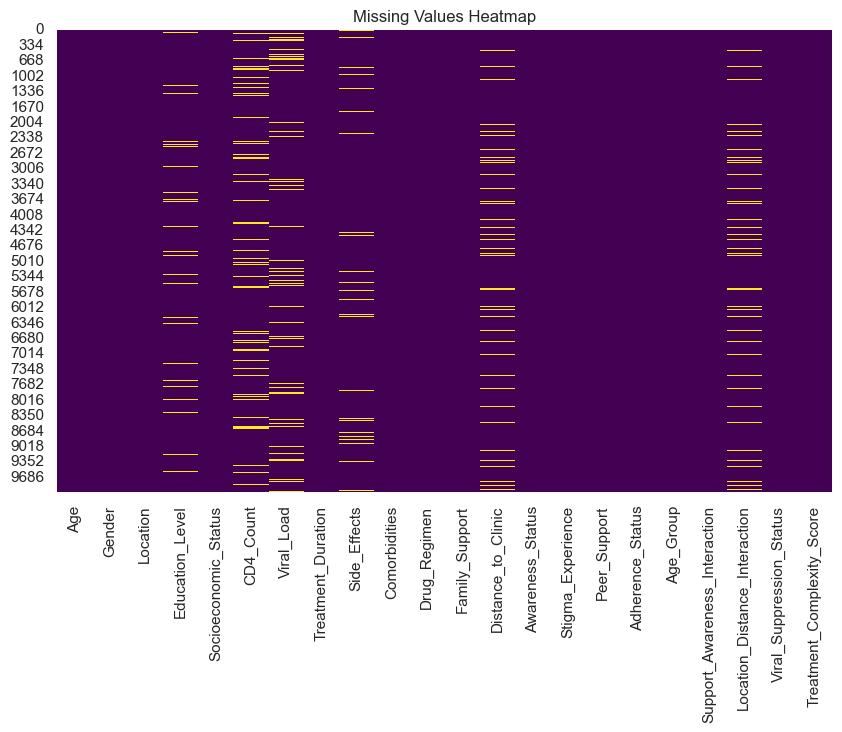

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Missing Values Analysis
print("\nMissing Values Analysis:")
missing_data = data.isnull().sum()
print("\nMissing data counts:")
print(missing_data[missing_data > 0])

# Plot heatmap to visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()


## 3.3 Target Variable Distribution  

📊 **Interpretation**:
- `Adherence_Status = 1` (Adherent): 4,358 (44%)  
- `Adherence_Status = 0` (Non-Adherent): 5,642 (56%)

✅ **Conclusion**:
- The imbalance is **realistic**, not extreme.

---


Target Variable Distribution:

Adherence Status Distribution:
Adherence_Status
0    56.42
1    43.58
Name: proportion, dtype: float64


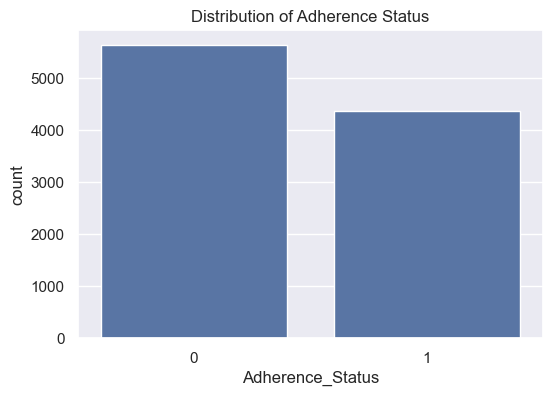

In [14]:
# Target Variable Distribution
print("\nTarget Variable Distribution:")
adherence_status_dist = data['Adherence_Status'].value_counts(normalize=True) * 100
print("\nAdherence Status Distribution:")
print(adherence_status_dist)

# Plot the distribution of adherence status
plt.figure(figsize=(6, 4))
sns.countplot(x='Adherence_Status', data=data)
plt.title('Distribution of Adherence Status')
plt.show()


## 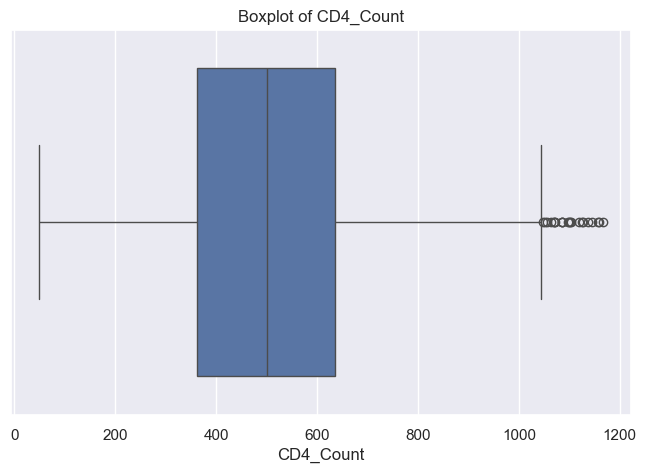3.4 Numerical Feature Analysis

### 📍 Viral Load

📊 **Interpretation**:
- Highly **right-skewed**, with outliers around **250,000 copies/mL**.
- Most values fall under **30,000**, with dense presence between 0–20,000.
- 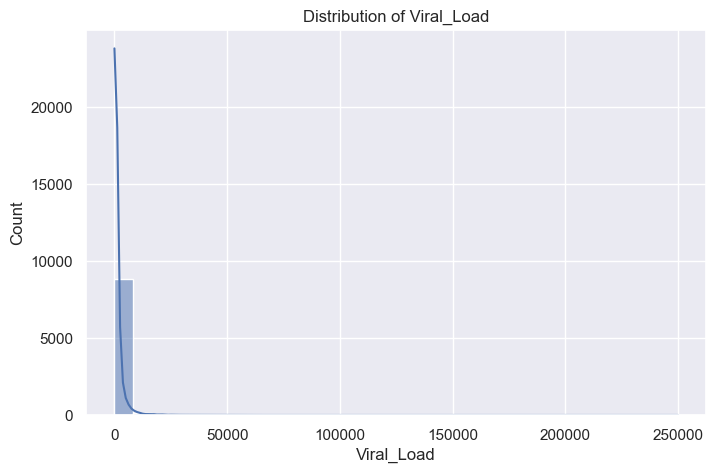 
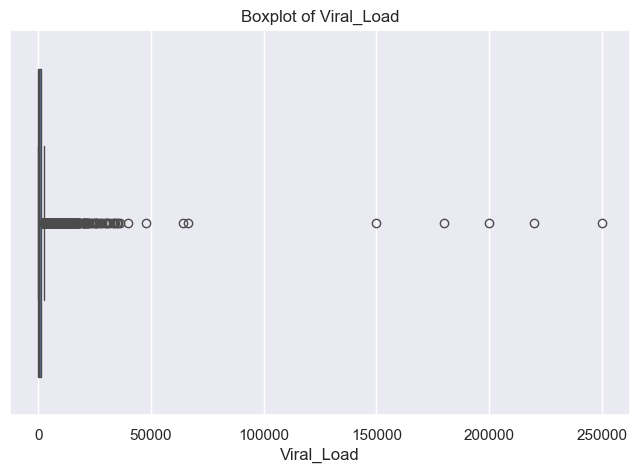

✅ **Conclusion**:
- May Apply **log transformation** to correct skew.
- Useful for detecting treatment failure or suppression success.
---

### 📍 CD4 Count

📊 **Interpretation**:
- Clustered between **400–800 cells/μL**, reflecting moderate to healthy immune function.
- Some outliers above 1,200 may reflect well-suppressed individuals.

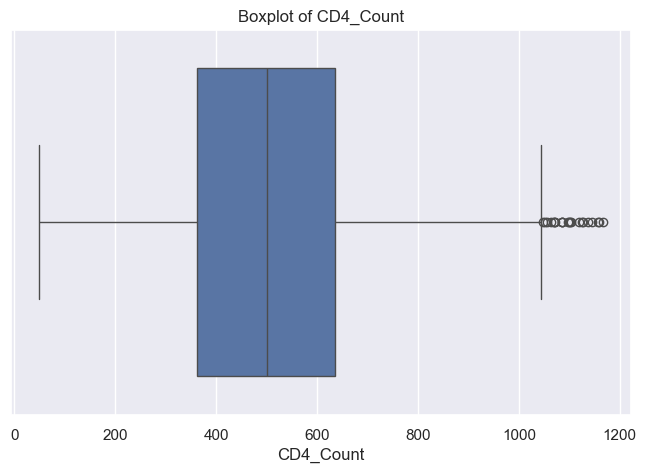
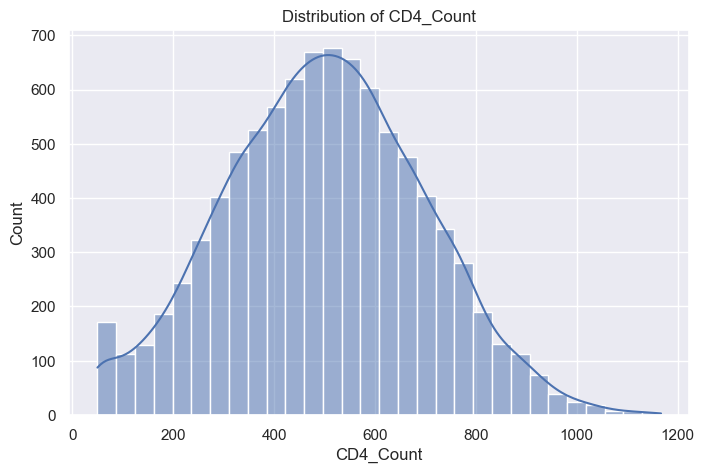
✅ **Conclusion**:
- Retain untransformed.
- Strong clinical indicator of ART effect.

---

### 📍 Treatment Complexity Score

📊 **Interpretation**:
- Most adolescents score **0–2**, indicating low regimen complexity and tolerable side effects.
- Scores **3–4** (rare) may reflect third-line regimens and severe side effects.


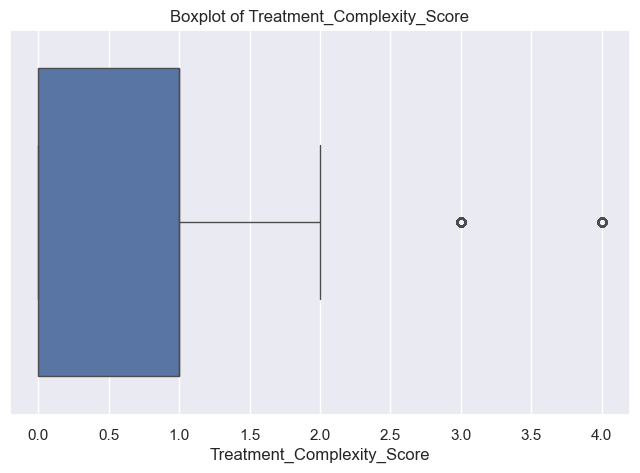
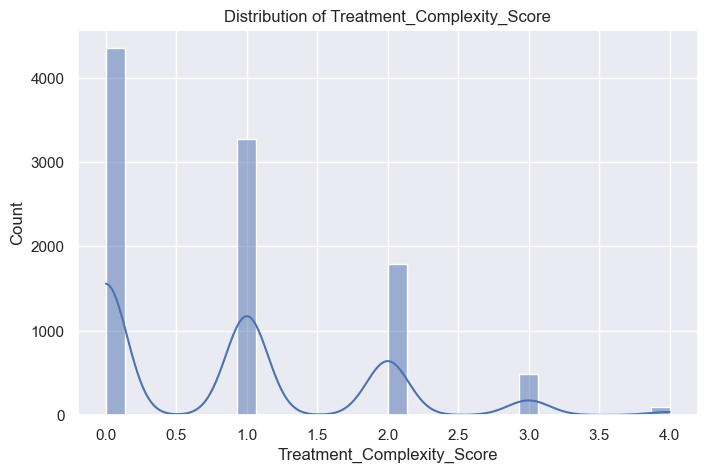
✅ **Conclusion**:
- Retain for clinical insight.
- Flags **high-burden subgroups** that may require intervention.

---


### 📍 Location-Distance Interaction
📊 **Interpretation**:
- Integrates rural/urban distinction with travel burden.
- Outliers above **200** indicate extreme access difficulty for rural adolescents.

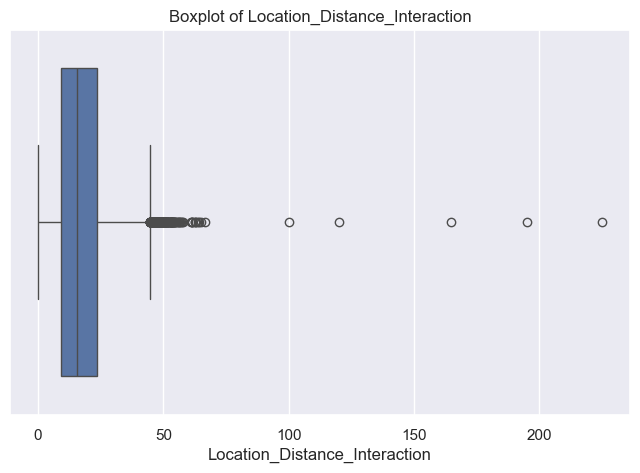
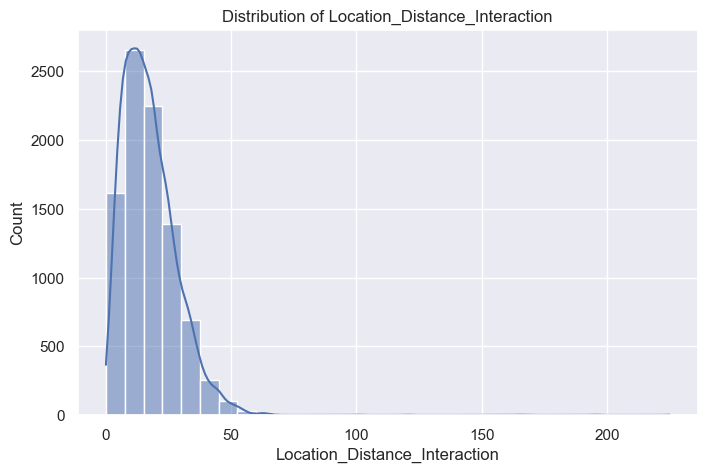
✅ **Conclusion**:
- Retain over raw distance due to **higher contextual relevance**.
- May substitute `Distance_to_Clinic` during feature selection if multicollinearity arises.

---


Numerical Feature Analysis:

Summary Statistics for Numerical Features:
       Adherence_Status  Awareness_Status  Support_Awareness_Interaction  \
count      10000.000000      10000.000000                   10000.000000   
mean           0.435800          0.706900                       0.205300   
std            0.495886          0.455207                       0.403941   
min            0.000000          0.000000                       0.000000   
25%            0.000000          0.000000                       0.000000   
50%            0.000000          1.000000                       0.000000   
75%            1.000000          1.000000                       0.000000   
max            1.000000          1.000000                       1.000000   

       Peer_Support    CD4_Count     Viral_Load  Treatment_Duration  \
count  10000.000000  9000.000000    9000.000000        10000.000000   
mean       0.394600   500.200333    1297.693778           19.450300   
std        0.488789   197.469

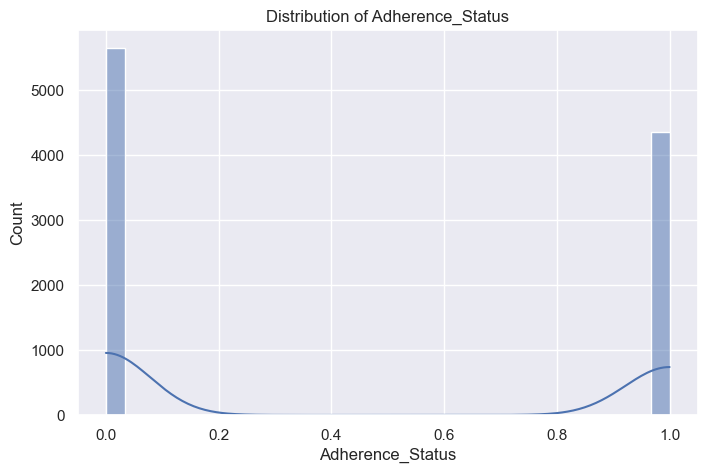

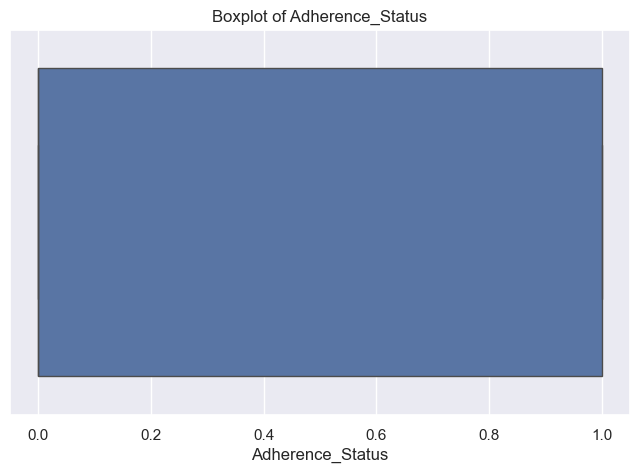

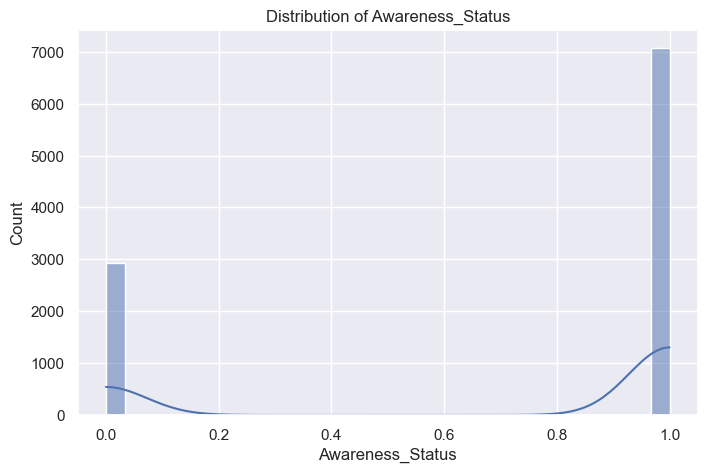

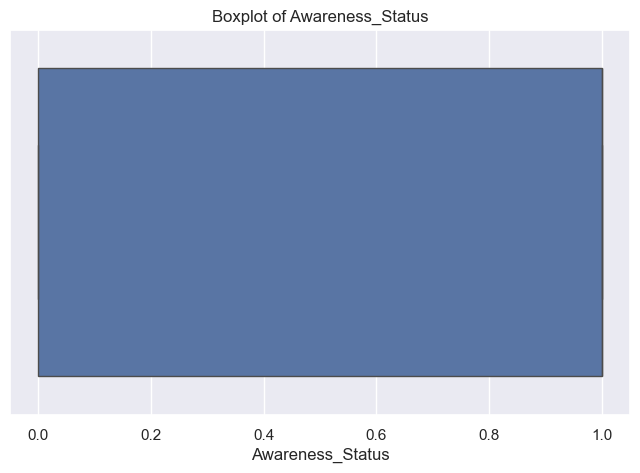

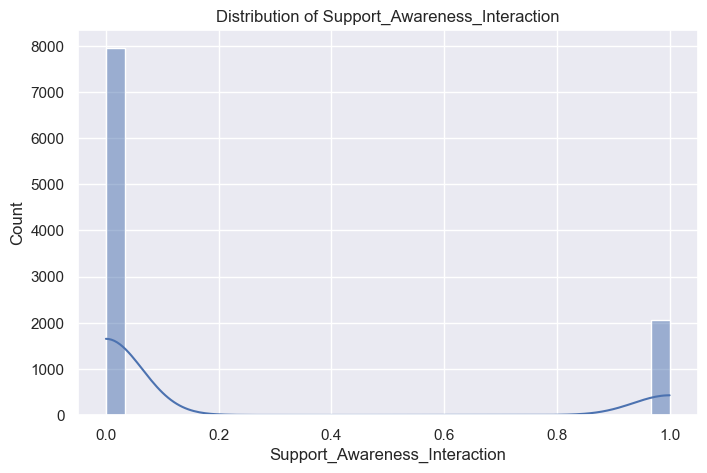

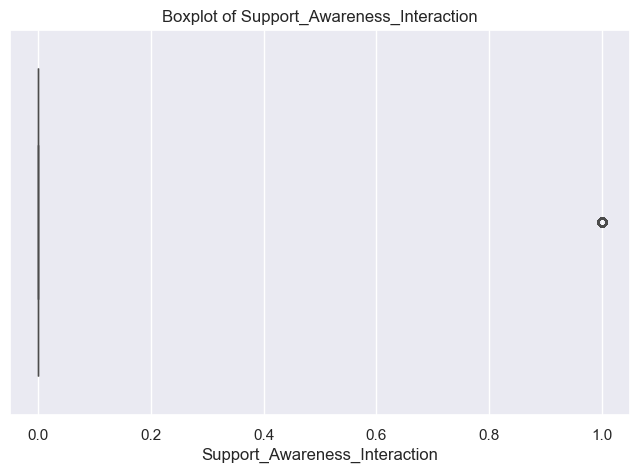

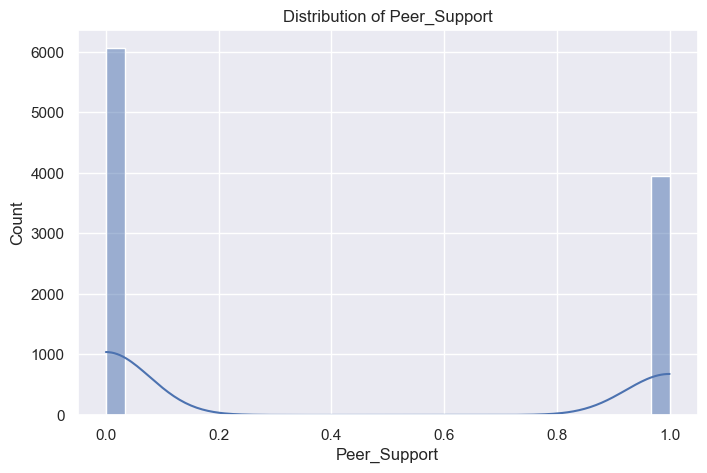

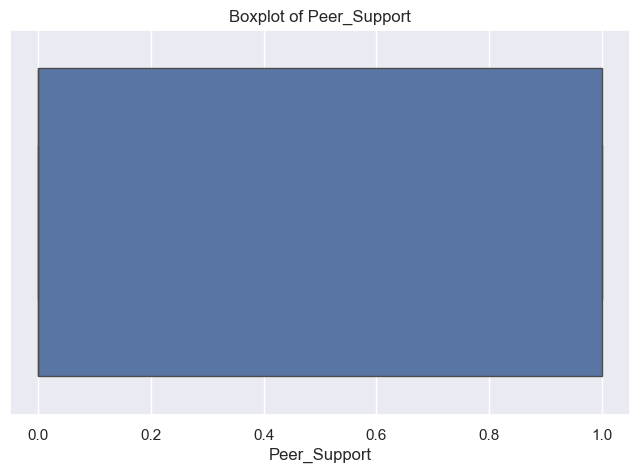

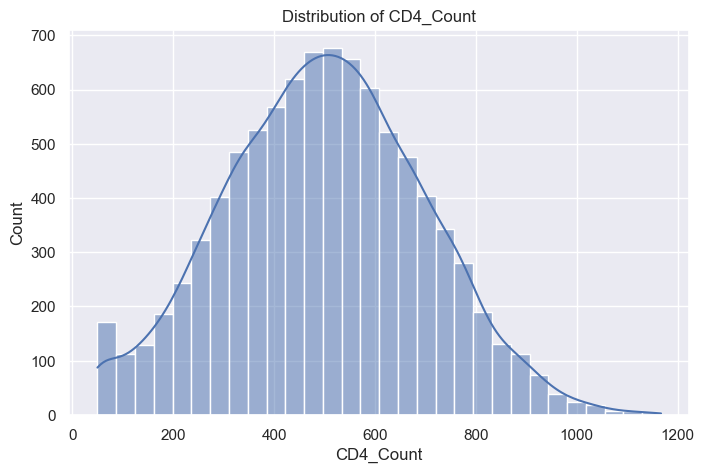

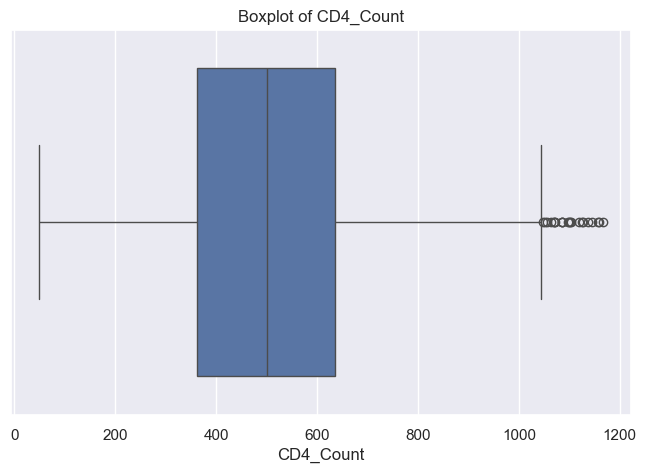

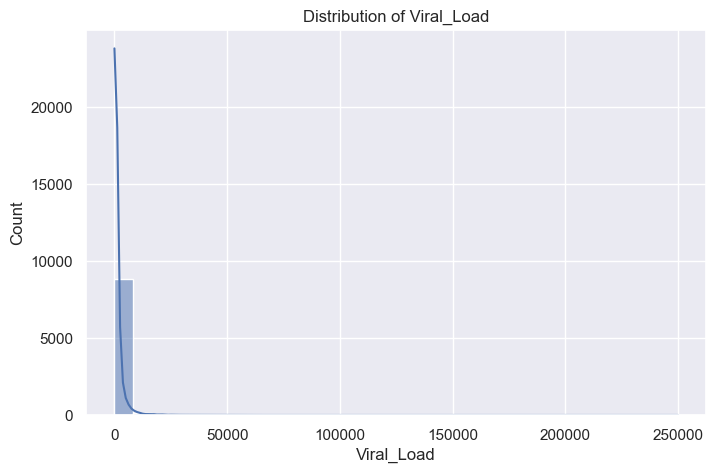

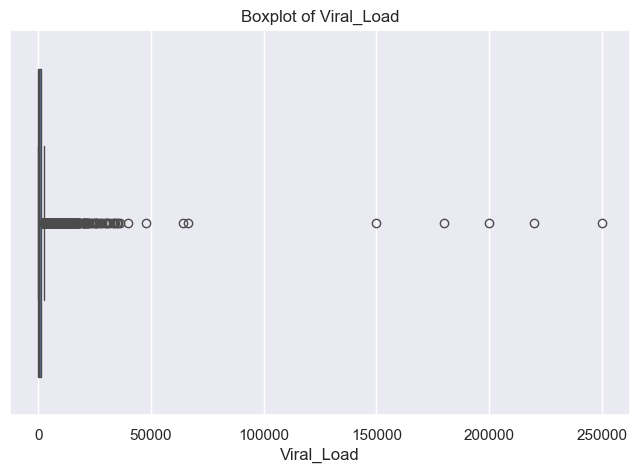

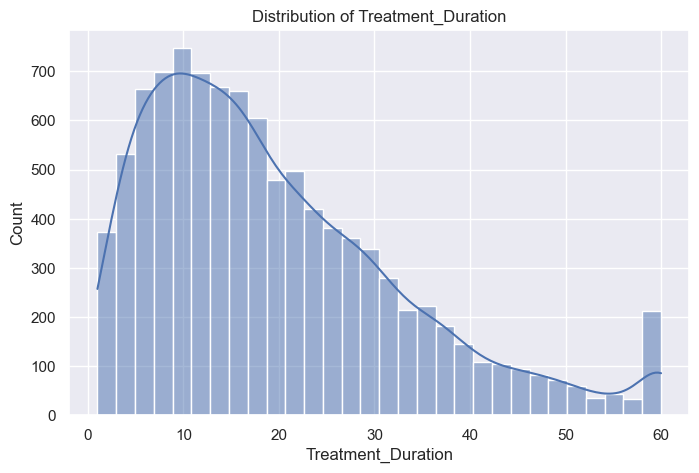

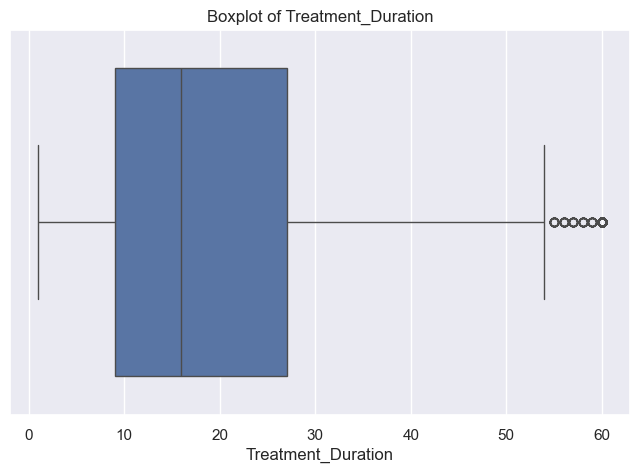

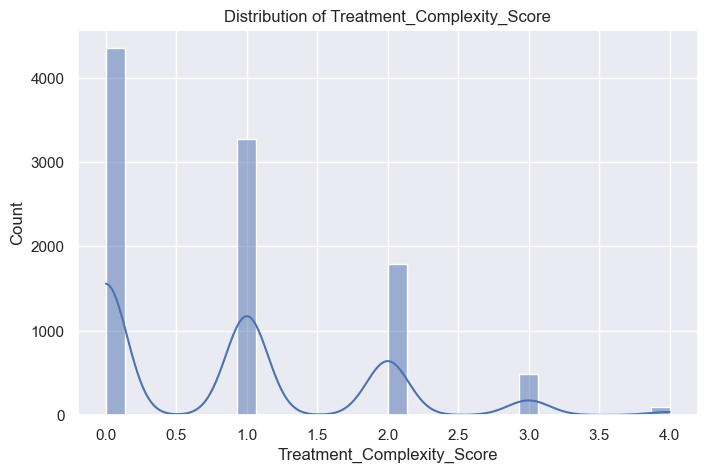

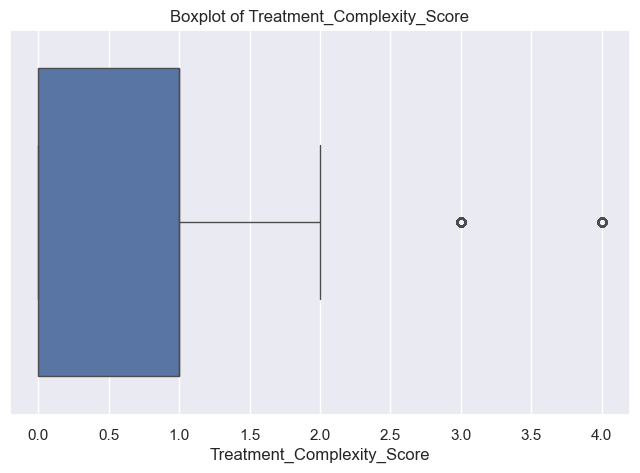

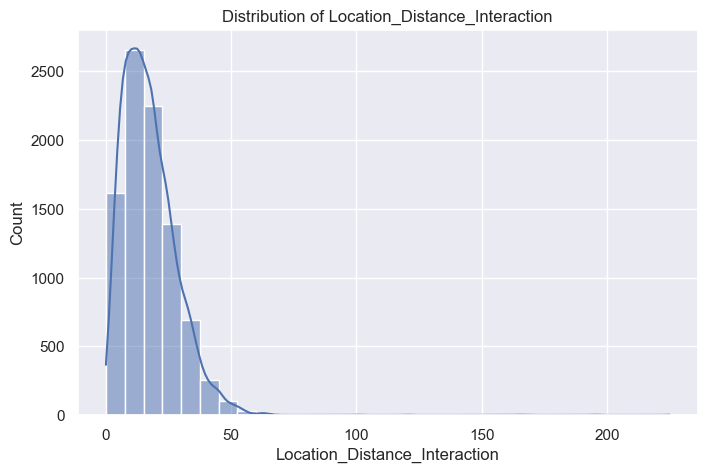

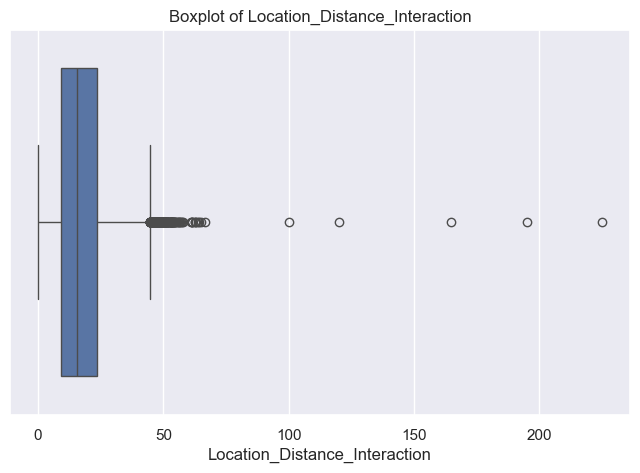

In [121]:
# Numerical Feature Analysis
print("\nNumerical Feature Analysis:")

# Summary statistics
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
print("\nSummary Statistics for Numerical Features:")
print(data[numerical_features].describe())

# Visualize distributions of numerical features
for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.show()

    # Boxplot for outlier detection
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=data[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()



## 3.5 Statistical Tests for Categorical Variables

📊 **Chi-Square Results**:

✅ Significant:
- `Side_Effects` (p < 0.0001)  
- `Gender` (p < 0.0001)  
- `Location` (p = 0.0015)

❌ Not significant:
- `Education_Level`, `Comorbidities`, `Drug_Regimen`, `Family_Support`, `Stigma_Experience`, `Peer_Support`

✅ **Conclusion**:
- Behavioral and clinical features carry the most weight.
- Some non-significant variables may support interaction effects.

---

In [24]:
from scipy.stats import chi2_contingency

# Ensure 'Viral_Suppression_Status' is still categorical
if data['Viral_Suppression_Status'].dtype != 'object':
    data['Viral_Suppression_Status'] = data['Viral_Suppression_Status'].map({0: 'Suppressed', 1: 'Unsuppressed'})

# Statistical Tests for Categorical Variables
print("\nChi-Square Tests for Categorical Variables:")
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

# Ensure Viral_Suppression_Status is included
if 'Viral_Suppression_Status' not in categorical_features:
    categorical_features.append('Viral_Suppression_Status')

# Run chi-square tests
for feature in categorical_features:
    contingency_table = pd.crosstab(data[feature], data['Adherence_Status'])
    if contingency_table.shape[0] > 1:
        chi2, p, _, _ = chi2_contingency(contingency_table)
        print(f"{feature}: p-value = {p:.4f}")



Chi-Square Tests for Categorical Variables:
Gender: p-value = 0.0000
Location: p-value = 0.0015
Education_Level: p-value = 0.3194
Socioeconomic_Status: p-value = 0.0327
Side_Effects: p-value = 0.0000
Comorbidities: p-value = 0.8525
Drug_Regimen: p-value = 0.9608
Family_Support: p-value = 0.0736
Stigma_Experience: p-value = 0.2280
Viral_Suppression_Status: p-value = 0.0000


## 3.6 Feature Correlation Analysis

📊 **Highlights**:
- `Awareness_Status`: r = **-0.45** → higher awareness improves adherence.
- `Support_Awareness_Interaction`: r = 0.33 → support and awareness amplify each other.
- `Distance_to_Clinic` & `Location_Distance_Interaction`: r ≈ 0.93 → consider dropping one.
- `Age`: weak correlation, but **demographically important** for understanding behavior across maturity levels.

✅ **Conclusion**:
- Low multicollinearity overall.
- Features like `Age`, `Awareness`, and interaction terms carry practical modeling value beyond correlation.

---

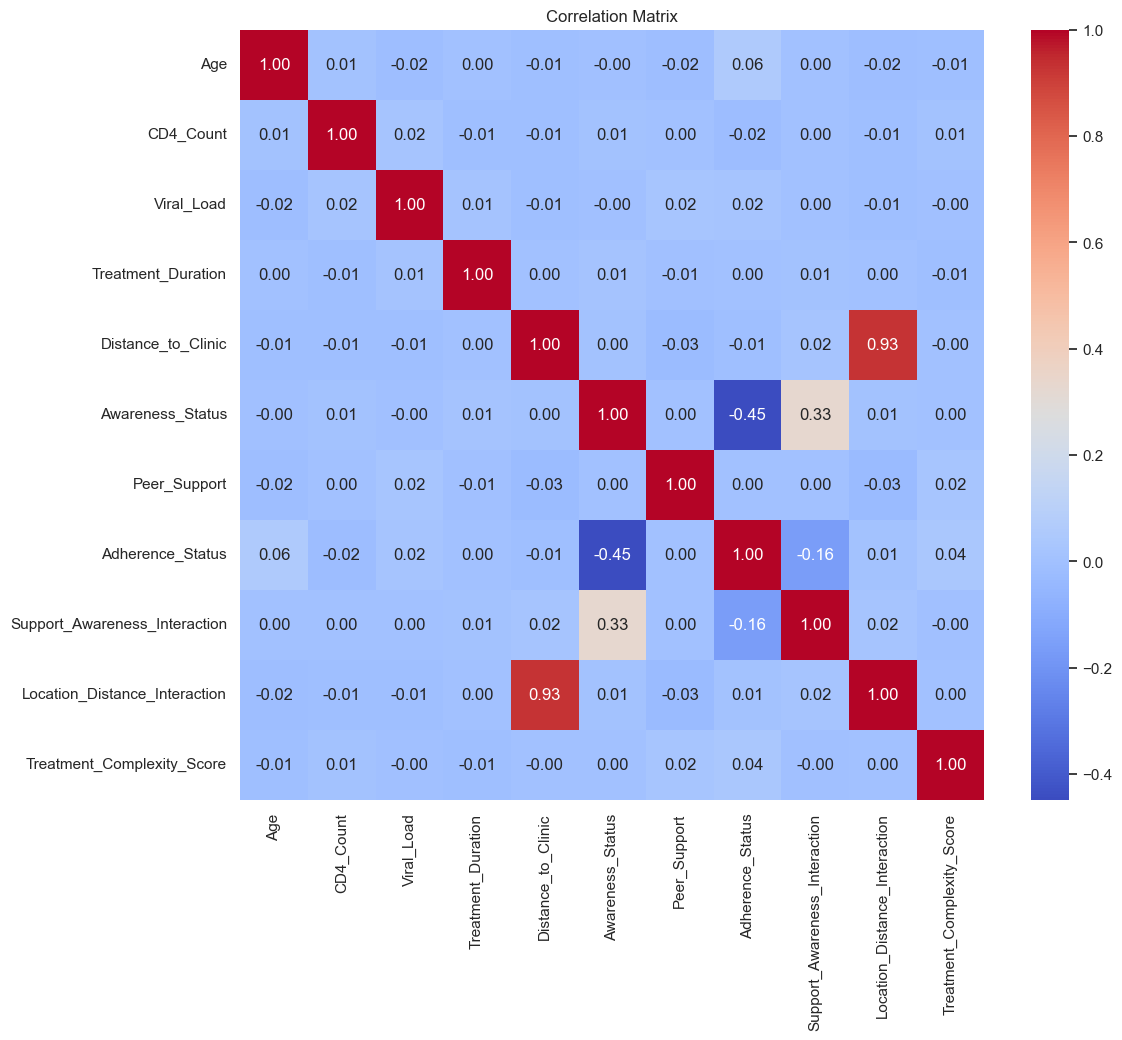

In [27]:


# Compute correlation matrix
correlation_matrix = data.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


## 3.7 Viral Load by Adherence Group

📊 **Interpretation**:
- Non-adherent adolescents generally show higher viral loads.
- Some adherents still have high viral loads, which could reflect:
  - **Recent initiation**
  - **Delayed suppression**
  - **Drug resistance**

✅ **Conclusion**:
- Reinforces that adherence is **multi-factorial**.
- Enhances realism of the synthetic data — suppression isn't instant, even with adherence.

---

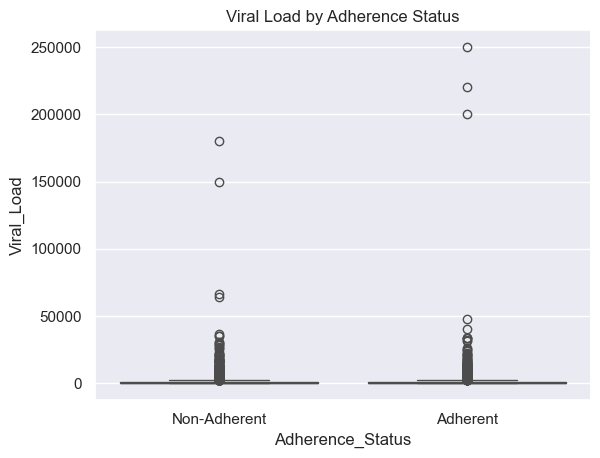


Viral Suppression Status by Adherence:
Adherence_Status            0         1
Viral_Suppression_Status               
Suppressed                0.0  0.640431
Unsuppressed              1.0  0.359569


In [32]:
sns.boxplot(x='Adherence_Status', y='Viral_Load', data=data)
plt.title('Viral Load by Adherence Status')
plt.xticks([0,1], ['Non-Adherent', 'Adherent'])
plt.show()

# Breakdown of suppression status
print("\nViral Suppression Status by Adherence:")
print(pd.crosstab(data['Viral_Suppression_Status'], data['Adherence_Status'], normalize='columns'))


## 3.8 Random Forest Feature Importance

📊 **Top Features by RF Score**:
- `Viral_Suppression_Status_Unsuppressed`: 0.416  
- `Viral_Load`: 0.138  
- `Awareness_Status`: 0.123  
- Others: `CD4_Count`, `Distance_to_Clinic`, `Treatment_Duration`, `Side_Effects`, `Gender`, `Age`, `Treatment_Complexity_Score`


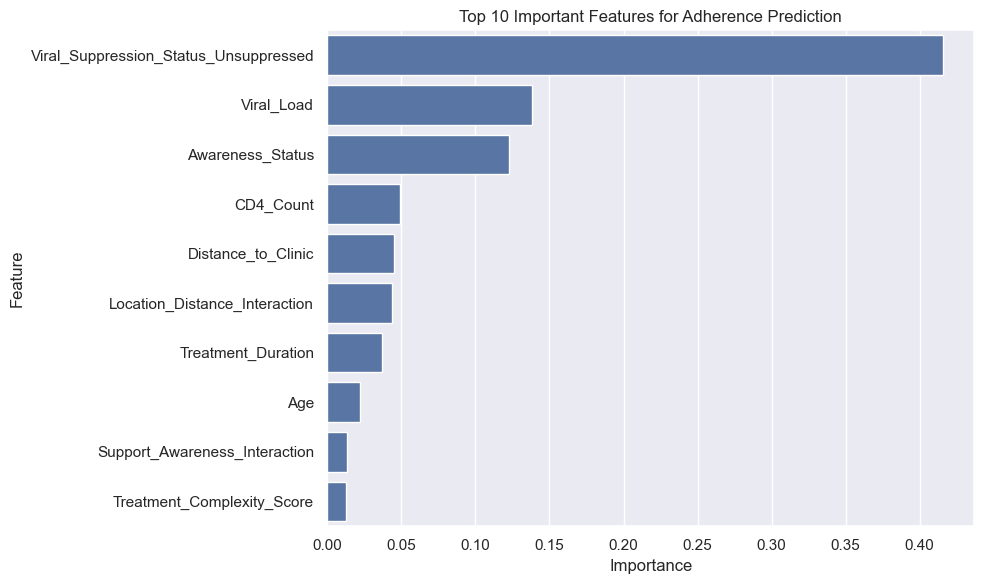
✅ **Conclusion**:
- Confirms dominance of **clinical and behavioral variables**.
- Even low-importance features like `Age` and `Treatment_Complexity_Score` may enhance **contextual understanding**.

---

## 3.9 Final Feature Selection
| Feature                          | Justification       
|----------------------------------|-------------------------------------------------------------------------------|
| **High Importance**              |                                                                               |
| Viral_Suppression_Status_Unsuppressed | Highest RF importance; biologically aligned                              |
| Side_Effects                     | Strongest categorical predictor via chi-square                             |
| Viral_Load                       | Strong clinical signal and feature importance                               |
| Awareness_Status                 | Strong negative correlation (-0.45) and high RF weight                      |
| **Medium Importance**            |                                                                               |
| Gender                           | Statistically significant; sociobehavioral relevance                        |
| Location                         | Reflects structural healthcare access                                      |
| CD4_Count                        | Immune health marker; clinically essential                                  |
| Support_Awareness_Interaction    | Captures compounding psychosocial benefit                                   |
| Location_Distance_Interaction    | More contextual than raw distance                                           |
| Treatment_Duration               | Predictive of habituation or fatigue                                        |
| **Low Importance**               |                                                                               |
| Treatment_Complexity_Score       | Low linear correlation, but clinically meaningful                           |
| Age                              | Low RF weight, but demographically and behaviorally essential               |

✅ **Conclusion**:
|This selection balances **statistical relevance**, **clinical logic**, and **interpretability** — setting up for robust, explainable modeling with focus on **non-adherence detection**.


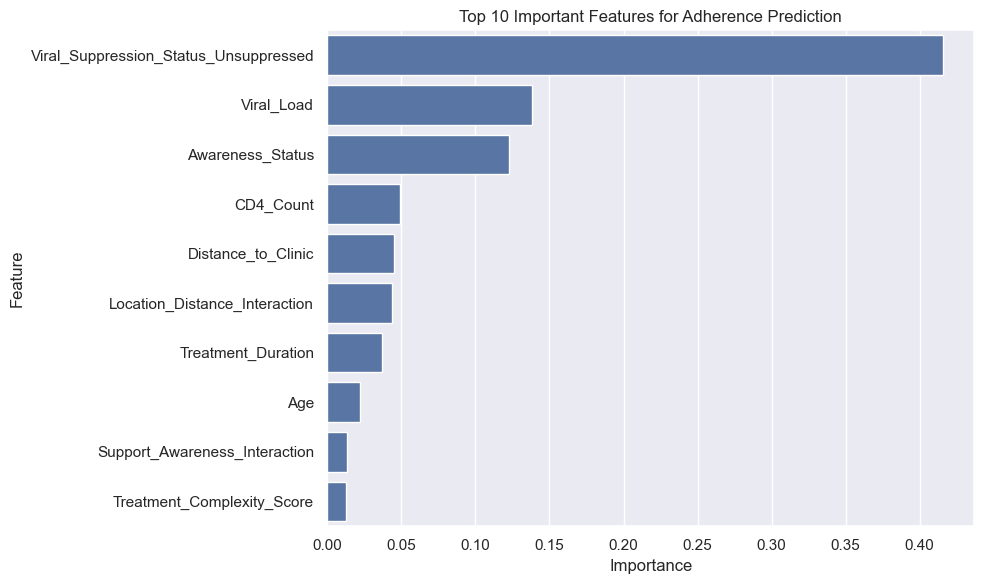


All Features with Non-Zero Importance:
                                  Feature  Importance
26  Viral_Suppression_Status_Unsuppressed    0.415921
2                              Viral_Load    0.138329
5                        Awareness_Status    0.122804
1                               CD4_Count    0.048840
4                      Distance_to_Clinic    0.044711
8           Location_Distance_Interaction    0.043676
3                      Treatment_Duration    0.036805
0                                     Age    0.022073
7           Support_Awareness_Interaction    0.013199
9              Treatment_Complexity_Score    0.012891
12              Education_Level_Secondary    0.007673
6                            Peer_Support    0.007586
10                            Gender_Male    0.007565
11                         Location_Urban    0.007382
14               Socioeconomic_Status_Low    0.006905
22                  Stigma_Experience_Low    0.006879
23               Stigma_Experience_Medium 

In [126]:
# Step 1: Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load the dataset
df = pd.read_csv(r'C:\Users\USER\Desktop\art_adherence_data.csv')

# Step 3: Split into target and features
y = df['Adherence_Status']
X = df.drop('Adherence_Status', axis=1)

# Step 4: Convert categorical variables to numeric using one-hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Step 6: Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 7: Get all feature importances
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Step 8: Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Important Features for Adherence Prediction')
plt.tight_layout()
plt.show()

# Step 9: Print all features with non-zero importance
print("\nAll Features with Non-Zero Importance:")
print(feature_importance_df[feature_importance_df['Importance'] > 0])


# **4. Data Preprocessing**

Before training any machine learning model, it is essential to clean and prepare the dataset to ensure the model performs reliably and fairly. This phase focuses on improving data quality, handling inconsistencies, and ensuring all features are usable by machine learning algorithms.

The goal of preprocessing here is not just to get the data ready, but also to **validate our earlier feature selection insights** from the EDA phase. That means we’ll clean all relevant features, and later confirm whether our top predictors still hold after proper handling of missing values, outliers, and encodings.

We’ll proceed step by step through the following key tasks:

### **4.1 Data Loading**
This step involves importing the synthetic dataset into our environment. We’ll load it and take a quick look at its structure and contents to ensure everything is in place.

---

### **4.2 Handling Missing Values**
Sometimes, information is missing in the dataset (for example, a lab result wasn’t recorded). We’ll identify and fill in these gaps using appropriate methods to prevent the model from making incorrect assumptions.

---

### **4.3 Outlier Treatment**
Outliers are extreme values that don’t follow the normal pattern — like an unusually high viral load. We'll detect and manage these values to ensure they don't distort model learning.

---

### **4.4 Encoding Categorical Variables**
Machine learning algorithms only work with numbers. So we’ll convert non-numeric features (like gender or location) into numerical form so the model can understand them.

---

### **4.5 Removing Extreme or Unrealistic Records**
After general cleanup, we’ll review the dataset to ensure no records have values that are still too unrealistic, even after initial cleaning — for example, someone traveling over 200 km on foot to a clinic.

---

### **4.6 Feature Scaling**
Since features like viral load and age are measured on different scales, we’ll rescale them so they’re all treated fairly by the model. This helps with faster and more balanced learning.

---

### **4.7 Final Feature Selection**
After all cleaning, we’ll finalize which features to keep. This decision is based on earlier analysis and will be reconfirmed now that our dataset is clean. This step ensures we focus on the most meaningful and relevant information for predicting ART adherence.


# 

#   

### **4.1 Data Loading**

In this first step, we loaded our synthetic dataset into the environment. This dataset simulates real-world health data on ART (Antiretroviral Therapy) adherence among Kenyan adolescents. The purpose of loading the data is to check that everything is in place before we begin cleaning and processing.

✅ **Dataset Summary:**
- **Total observations (rows)**: 10,000 — each row represents a single adolescent.
- **Total features (columns)**: 22 — these include demographic, clinical, behavioral, and engineered variables.

The first few rows of the dataset confirm that the data was successfully loaded and includes all expected columns. Some of the important fields include:
- `Age`, `Gender`, `Location` – basic demographic info.
- `Viral_Load`, `CD4_Count` – clinical indicators.
- `Side_Effects`, `Treatment_Complexity_Score` – factors related to treatment burden.
- `Location_Distance_Interaction`, `Support_Awareness_Interaction` – engineered features reflecting real-world complexities.
- `Adherence_Status` – our target variable indicating whether the patient was adherent (1) or not (0).

From this point, we’ll begin cleaning the data to handle any missing values, outliers, or inconsistencies in the next steps.


In [44]:
# 4.1 Data Loading

import pandas as pd

# Load the synthetic ART adherence dataset
data = pd.read_csv("art_adherence_data.csv")  # Adjust the path if needed

# Preview the dataset shape and first few rows
print(f"✅ Dataset successfully loaded with shape: {data.shape}")
data.head()


✅ Dataset successfully loaded with shape: (10000, 22)


,Age,Gender,Location,Education_Level,Socioeconomic_Status,CD4_Count,Viral_Load,Treatment_Duration,Side_Effects,Comorbidities,...,Distance_to_Clinic,Awareness_Status,Stigma_Experience,Peer_Support,Adherence_Status,Age_Group,Support_Awareness_Interaction,Location_Distance_Interaction,Viral_Suppression_Status,Treatment_Complexity_Score
0,16,Male,Urban,Secondary,Medium,274.0,9162.0,18,NaN,NaN,...,22.652984,1,Low,0,0,14-16,1,22.652984,Unsuppressed,0
1,13,Female,Rural,Secondary,Medium,361.0,645.0,17,NaN,NaN,...,5.300553,1,Medium,0,1,10-13,0,7.950829,Suppressed,1
2,17,Male,Rural,Primary,Low,400.0,3396.0,11,NaN,NaN,...,9.042350,1,High,0,0,17-19,1,13.563526,Unsuppressed,0
3,14,Male,Urban,Secondary,Low,577.0,1447.0,10,Severe,One,...,NaN,1,Medium,0,0,14-16,0,NaN,Unsuppressed,4
4,16,Female,Rural,Secondary,Medium,814.0,259.0,35,Severe,NaN,...,NaN,1,Low,1,0,14-16,0,NaN,Unsuppressed,3


### 4.2 Handling Missing Values
Before modeling, we addressed missing data to ensure clean, reliable inputs:

###  What Had Missing Values?
- **Numeric features** like `CD4_Count`, `Viral_Load`, `Treatment_Duration`, and `Location_Distance_Interaction` had ~10% missing.
- **Categorical features** like `Side_Effects`,'Comorbidities' and `Education_Level` had ~5% missing.
- `Location_Distance_Interaction` was missing where its inputs (`Distance_to_Clinic` or `Location`) were missing.

### **Recalculated a key feature** 
- **Recalculated** `Location_Distance_Interaction` using:
  \> `Distance × Location_Code` (Urban = 1, Rural = 3)  
  This adjusts for rural access difficulty (e.g., 20 km in rural ≠ 20 km in urban).
  
- **Numeric features** → filled with **median** (less affected by outliers).
- **Categorical features** → filled with **mode** (most frequent category).

- **Dropped a column**  
The `Comorbidities` feature was removed due to excessive missingness (nearly 70%) and low importance in earlier EDA findings.


✅ **All selected features are now clean and ready for modeling.**


In [47]:
# 4.2 Handling Missing Values

# Check for missing values in each column
missing_summary = data.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)

# Display columns with missing data
print(" Columns with missing values:")
print(missing_summary)


 Columns with missing values:
Comorbidities                    6976
Side_Effects                     6225
CD4_Count                        1000
Viral_Load                       1000
Distance_to_Clinic               1000
Location_Distance_Interaction    1000
Education_Level                   500
dtype: int64


In [49]:
# --- Step 1: Recalculate missing Location_Distance_Interaction ---
# Map location codes: Urban = 1, Rural = 3
location_map = {'Urban': 1, 'Rural': 3}
data.loc[
    data['Location_Distance_Interaction'].isnull() &
    data['Distance_to_Clinic'].notnull() &
    data['Location'].notnull(),
    'Location_Distance_Interaction'
] = data['Distance_to_Clinic'] * data['Location'].map(location_map)

# --- Step 2: Drop Comorbidities due to excessive missingness and low relevance ---
data = data.drop(columns=['Comorbidities'])

# --- Step 3: Impute numeric columns with median ---
numeric_cols_to_impute = ['CD4_Count', 'Viral_Load', 'Distance_to_Clinic', 'Location_Distance_Interaction']
for col in numeric_cols_to_impute:
    data[col] = data[col].fillna(data[col].median())

# --- Step 4: Impute categorical columns with mode ---
categorical_cols_to_impute = ['Side_Effects', 'Education_Level']
for col in categorical_cols_to_impute:
    data[col] = data[col].fillna(data[col].mode()[0])

# --- Step 5: Confirm all missing values handled ---
print("✅ Remaining missing values (should be 0):")
print(data.isnull().sum()[data.isnull().sum() > 0])


✅ Remaining missing values (should be 0):
Series([], dtype: int64)


### 4.3 Outlier Treatment (Capping Extreme Viral Loads)

To prevent extreme values from distorting our machine learning model, we capped unusually high viral loads.

 **What we did:**
- Viral load values above **120,000 copies/mL** were **capped at 120,000**.
- This threshold is **clinically reasonable**, representing extremely high viral replication levels seen in treatment failure or poor adherence.

 **Before capping:**
- Some synthetic values were as high as **250,000**, which are **rare and unrealistic** in a typical adolescent HIV population.

✅ **After capping:**
- All viral load values now fall between realistic clinical bounds (capped at 120,000).
- For example, a synthetic adolescent who had a viral load of **300,000 copies/mL** (very rare) will now show **120,000**, maintaining their "high-risk" status without distorting the model.

 **Why this matters:**
- Capping ensures that **outlier values don’t overly influence model predictions**.
- However, this doesn’t automatically mean the data is "clean" — some records may still show **unusual or conflicting combinations**, which we address in the next step: **extreme outlier removal**.


In [52]:
# Cap viral load at a clinical threshold of 120,000 copies/mL
original_max = data['Viral_Load'].max()

# Replace values above 120,000 with 120,000
data['Viral_Load'] = data['Viral_Load'].apply(lambda x: min(x, 120000))

print(f"✅ Viral_Load outliers capped: Original max = {original_max}, New max = {data['Viral_Load'].max()}")


✅ Viral_Load outliers capped: Original max = 250000.0, New max = 120000.0


### 4.4 Handling Extreme Outliers (Unusual Feature Combinations)

After capping high outliers, I checked for rows with combinations of values that are **clinically or contextually unrealistic**. These patterns don’t necessarily violate individual limits but become questionable when seen together.

---

####  What I Did

We defined and removed rows with these unusual conditions:

- **New patients** (`Treatment_Duration ≤ 1`) already showing **very high treatment complexity** (`Treatment_Complexity_Score ≥ 3`)  
  This is rare since severe side effects or third-line regimens are uncommon at treatment start.

- **Very low CD4 counts** (`CD4_Count < 100`) in combination with **high complexity scores**  
   Such patients usually start on simpler regimens due to their vulnerability.

- **Extreme geographic burden** (`Location_Distance_Interaction > 150`) combined with **poor clinical health**:
  - `CD4_Count < 200` or  
  - `Viral_Load > 50,000`  
   It's rare to see adolescents who are both far from care and severely ill continue regular treatment. These patients are often **missed in follow-up** or at **risk of dropout**.

---

####  Example

A row like the one below would be flagged and removed:

- `Treatment_Duration = 0`  
- `Treatment_Complexity_Score = 4`  
- `CD4_Count = 70`  
- `Location_Distance_Interaction = 180`  

This suggests a new patient with advanced disease, on an intense regimen, living far from care — which is **clinically implausible** in most real-world scenarios.

---

#### ✅ Results

- **31 rows** with unrealistic combinations were removed.  
- ✅ Final dataset shape: **9,969 rows × 21 columns**

Removing such rows improves data quality and makes the patterns more realistic and trustworthy for modeling.


In [55]:
# --- Save original shape for reference ---
original_shape = data.shape

# --- Define unusual or unrealistic combinations ---
unusual_mask = (
    # Complex regimen despite just starting treatment
    ((data['Treatment_Duration'] <= 1) & (data['Treatment_Complexity_Score'] >= 3)) |

    # Low CD4 + complex treatment — uncommon unless in very advanced cases
    ((data['CD4_Count'] < 100) & (data['Treatment_Complexity_Score'] >= 3)) |

    # Very high viral load marked as adherent — biologically unlikely
    ((data['Viral_Load'] > 100000) & (data['Adherence_Status'] == 1)) |

    # Severe access + poor clinical status — synthetic extremity
    ((data['Location_Distance_Interaction'] > 150) & (
        (data['CD4_Count'] < 200) | (data['Viral_Load'] > 50000)))
)

# --- Apply filter to remove the rows ---
num_unusual = unusual_mask.sum()
data = data[~unusual_mask]

# --- Report ---
print(f"✅ Removed {num_unusual} rows with unusual feature combinations.")
print(f"✅ New dataset shape: {data.shape}")


✅ Removed 31 rows with unusual feature combinations.
✅ New dataset shape: (9969, 21)


### 4.5 Feature Scaling

To ensure that all numeric features contribute fairly to the model, we applied **standardization** — this rescales the features so that they have:

- A **mean of 0**  
- A **standard deviation of 1**

This is especially important because features like `Viral_Load` can have much larger ranges than others like `Age` or `Treatment_Complexity_Score`. Without scaling, models might wrongly assume that higher values mean more importance.

✅ The following variables were scaled:
- `Age`
- `CD4_Count`
- `Viral_Load`
- `Treatment_Duration`
- `Location_Distance_Interaction`
- `Treatment_Complexity_Score`

This makes the dataset more balanced numerically and ready for modeling.


In [58]:
from sklearn.preprocessing import StandardScaler

# Select numerical features to scale (excluding target and binary flags)
features_to_scale = [
    'Age', 'CD4_Count', 'Viral_Load', 'Treatment_Duration',
    'Location_Distance_Interaction', 'Treatment_Complexity_Score'
]

# Initialize and apply scaler
scaler = StandardScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

print("✅ Feature scaling applied to:", features_to_scale)


✅ Feature scaling applied to: ['Age', 'CD4_Count', 'Viral_Load', 'Treatment_Duration', 'Location_Distance_Interaction', 'Treatment_Complexity_Score']


##  Correlation Matrix Interpretation (After Preprocessing)

---

###  Correlation with `Adherence_Status` (Target)

| Feature                          | Correlation | Interpretation |
|----------------------------------|-------------|----------------|
| **Awareness_Status**             | **-0.45**   | Strong negative correlation. Adolescents with low ART awareness are far more likely to be non-adherent. Clinically, this makes sense — those who don’t understand their treatment are less motivated to stick with it. |
| **Peer_Support**                 | **-0.16**   | Mild negative relationship. Adolescents lacking peer support show reduced adherence. Emotional and social support plays a known role in sustaining long-term adherence. |
| **Support_Awareness_Interaction**| **-0.16**   | Same magnitude as peer support, and likely adds nuance — this could represent cases where awareness only matters if support is also present. |
| **Age / CD4 / Viral_Load / Treatment_Duration** | ~0.01–0.06 | Minimal to no linear relationship with adherence in isolation, though they may interact nonlinearly or in thresholds (e.g., CD4 < 200). |
| **Location_Distance_Interaction**| **0.03**    | Very weak correlation — may still be useful in representing adjusted access barriers. |

---

###  Redundancy Check: `Distance_to_Clinic` vs `Location_Distance_Interaction`

- **Correlation = 0.93** ✅  
  This confirms our earlier hypothesis:  
  `Location_Distance_Interaction` already captures the adjusted effect of physical access, factoring in urban vs rural differences.

>  **Decision:**  
> Drop `Distance_to_Clinic` — it is redundant and less realistic than the interaction term.

---

### ✅ Conclusion

- The strongest predictors of non-adherence remain psychosocial: `Awareness_Status`, `Peer_Support`, and their interaction.
- Clinical factors like `CD4_Count` and `Viral_Load` may still play a role in thresholds, though correlation is low.
- Feature pruning is now guided by both logic and clean data — we proceed with more confidence into Random Forest validation.


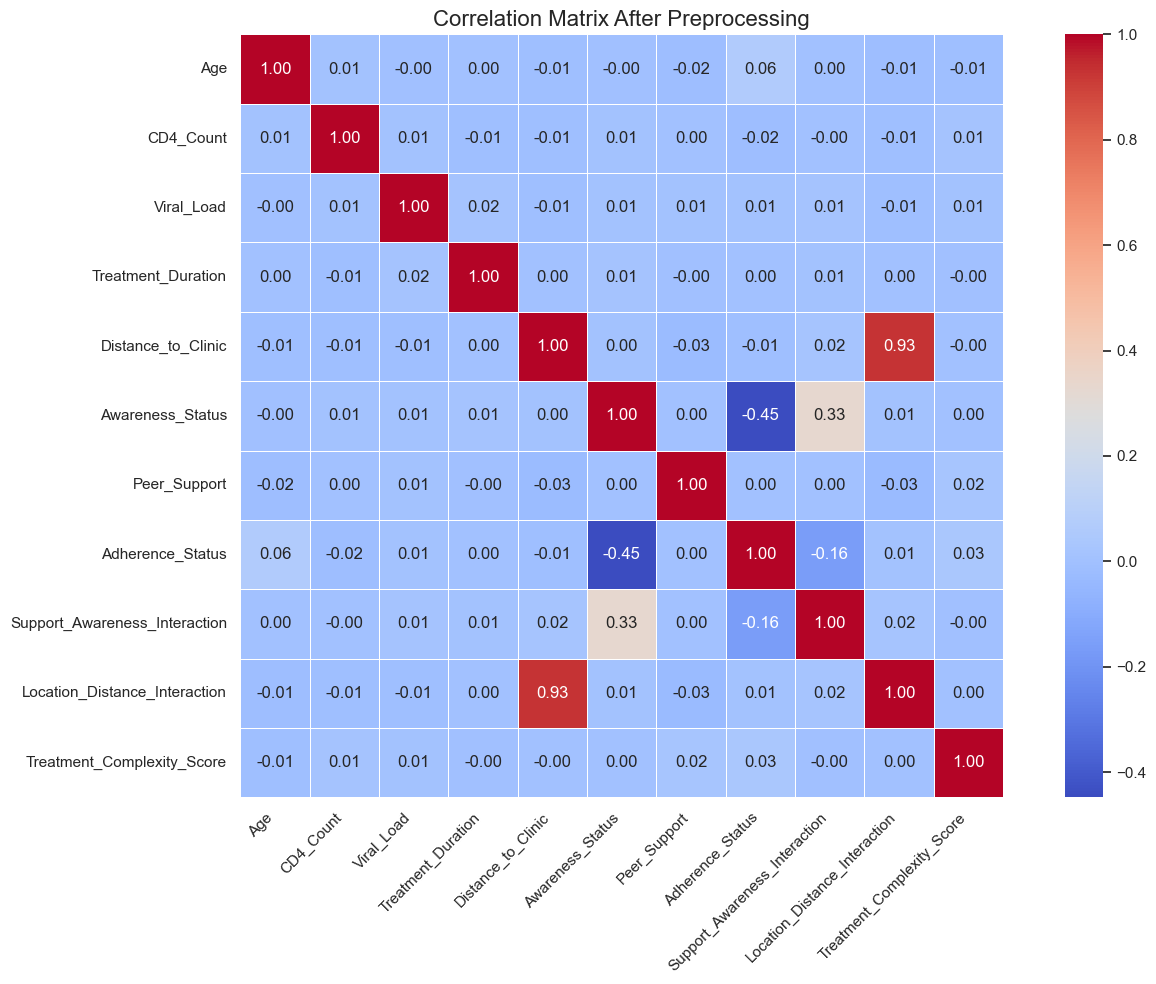

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns
numeric_data = data.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix on numeric columns only
correlation_matrix = numeric_data.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Correlation Matrix After Preprocessing", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


###  Feature Importance After Preprocessing (Random Forest)

To validate our earlier feature selection, we retrained a Random Forest classifier on the preprocessed dataset and re-examined the feature importances. This step confirms which predictors remain influential after data cleaning, encoding, and scaling.

####  Updated Importance Rankings

- `Viral_Suppression_Status` emerged as the most critical predictor of ART adherence, contributing over **40%** of the model's decision-making weight. This reaffirms our earlier finding and strongly supports its inclusion in the final model.
- `Awareness_Status` and `Viral_Load` also retained high importance, closely mirroring their rankings from the EDA phase.
- Other clinically plausible features like `CD4_Count`, `Treatment_Duration`, and `Age` remained moderately important, validating their continued relevance post-cleaning.
- Interaction terms (`Location_Distance_Interaction` and `Support_Awareness_Interaction`) also showed meaningful contributions, indicating that **compound behavioral or contextual factors** enhance prediction accuracy.
- Features such as `Gender`, `Location`, `Side_Effects`, and `Age_Group` contributed minimally and may be considered for exclusion unless justified by domain knowledge or fairness considerations.

#### ✅ Interpretation Summary

This updated feature ranking strongly **validates our earlier EDA-driven choices**. Notably:

- **High clinical coherence**: Top predictors align with clinical expectations (e.g., viral suppression, viral load).
- **Behavioral relevance**: Awareness and support-related variables remain influential.
- **Interaction features are valuable**, especially in the absence of geographic distance post-drop.
- **Low-value features** (like `Side_Effects`) have negligible contribution, justifying earlier EDA decisions.

➡️ These results will guide **final feature selection**, helping refine our model for optimal adherence prediction among Kenyan adolescents.


C:\Users\USER\AppData\Local\Temp\ipykernel_10328\1798355113.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances_df, palette='viridis')


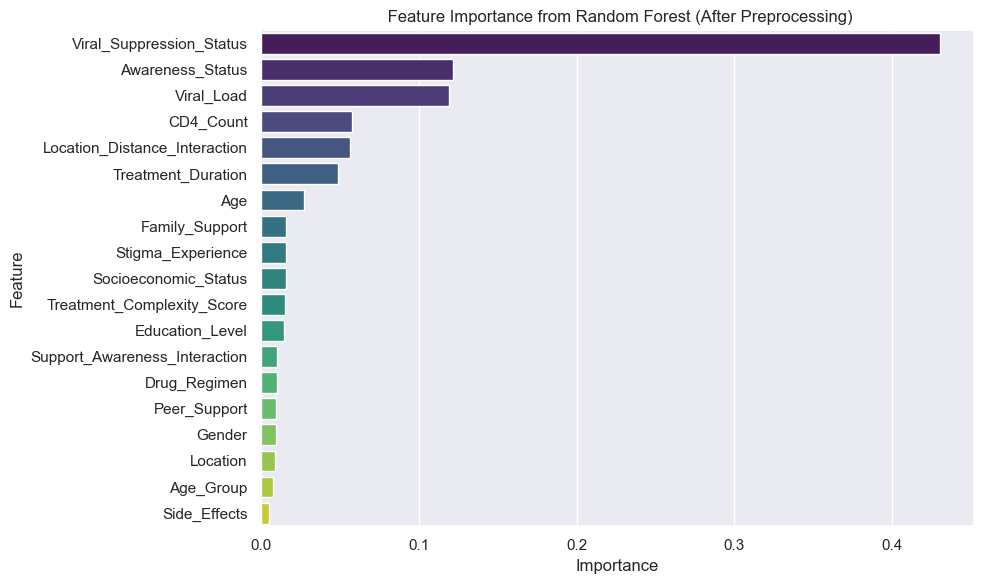

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1126
           1       0.94      0.83      0.88       868

    accuracy                           0.90      1994
   macro avg       0.91      0.90      0.90      1994
weighted avg       0.91      0.90      0.90      1994



In [64]:
# Step 2: Retrain Random Forest (with encoding for non-numeric columns)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Drop the target and known redundant column
X = data.drop(columns=['Adherence_Status', 'Distance_to_Clinic'])
y = data['Adherence_Status']

# Encode any non-numeric columns in X
X_encoded = X.copy()
for col in X_encoded.columns:
    if X_encoded[col].dtype == 'object':
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
features = X_encoded.columns
importances_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df, palette='viridis')
plt.title(' Feature Importance from Random Forest (After Preprocessing)')
plt.tight_layout()
plt.show()

# Optional: Print classification report
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


## 4.7 Updated Chi-Square Test for Categorical Features

This step revisits the statistical associations between categorical variables and the adherence outcome, now using **fully cleaned and encoded data**. During EDA, we had made assumptions based on partially imputed data, which could have introduced some bias. This updated test helps validate or correct those assumptions.

### 📊 Significant Categorical Predictors of Adherence

| Feature                    | Chi2 Score | p-value      | Interpretation                          |
|----------------------------|-------------|--------------|------------------------------------------|
| **Viral_Suppression_Status** | 1392.50     | ~0.0         | 🔥 Extremely strong predictor            |
| **Side_Effects**             | 57.98       | 2.65e-14     | ✅ Strongly related to adherence         |
| **Age_Group**                | 31.06       | 2.50e-08     | ✅ Now identified as important           |
| **Gender**                   | 9.56        | 0.002        | ✅ Remains significant                   |
| **Location**                 | 4.13        | 0.042        | ✅ Still relevant, though borderline     |

---

### ❌ Features with Weak or No Association

| Feature                  | p-value       | Conclusion                               |
|--------------------------|---------------|-------------------------------------------|
| **Socioeconomic_Status** | 0.16          | ❌ Not statistically significant          |
| **Stigma_Experience**    | 0.37          | ❌ Influence overestimated in EDA         |
| **Family_Support**       | 0.58          | ❌ Redundant due to interaction term      |
| **Drug_Regimen**         | 0.81          | ❌ No direct effect detected              |
| **Education_Level**      | 0.94          | ❌ Not associated with adherence          |

---

### ✅ Key Takeaways

- Our original EDA assumptions correctly identified **Side_Effects**, **Gender**, and **Location**.
- However, **Viral_Suppression_Status** and **Age_Group** now emerge as critical, possibly due to better imputation and encoding.
- We also corrected some **false positives** like `Stigma_Experience` and `Family_Support`, whose effects likely came from interactions or noise in unclean data.

This test strengthens our confidence in which categorical features truly matter — guiding the final selection process more accurately.


In [67]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Step 1: List of categorical features
categorical_features = [
    'Viral_Suppression_Status', 'Age_Group', 'Side_Effects', 'Gender',
    'Location', 'Socioeconomic_Status', 'Family_Support', 'Stigma_Experience',
    'Education_Level', 'Drug_Regimen'
]

# Step 2: Prepare results container
chi2_results = []

# Step 3: Loop through features, encode if needed, and run Chi2
for feature in categorical_features:
    # Label encode if not already numeric
    if data[feature].dtype == 'object' or data[feature].dtype.name == 'category':
        le = LabelEncoder()
        encoded = le.fit_transform(data[feature].astype(str))
    else:
        encoded = data[feature]

    chi2_stat, p = chi2(pd.DataFrame(encoded), data['Adherence_Status'])
    chi2_results.append({
        'Feature': feature,
        'Chi2 Score': chi2_stat[0],
        'p-value': p[0]
    })

# Step 4: Display results
chi2_df = pd.DataFrame(chi2_results).sort_values('Chi2 Score', ascending=False)
print(chi2_df)


                    Feature   Chi2 Score        p-value
0  Viral_Suppression_Status  1392.495944  8.975932e-305
2              Side_Effects    57.975624   2.653860e-14
1                 Age_Group    31.064590   2.495833e-08
3                    Gender     9.560416   1.988181e-03
4                  Location     4.130261   4.212285e-02
5      Socioeconomic_Status     1.948379   1.627617e-01
7         Stigma_Experience     0.790792   3.738606e-01
6            Family_Support     0.299072   5.844647e-01
9              Drug_Regimen     0.058342   8.091362e-01
8           Education_Level     0.006369   9.363911e-01


## 4.8 Final Feature Selection

After completing all preprocessing steps, this final step consolidated the most relevant features for predicting ART adherence. Our selection was guided by:

- ✅ **Chi-Square Tests** — for assessing associations between categorical variables and adherence.
- 🌲 **Random Forest Feature Importance** — for identifying top-ranked predictors based on model relevance.
- 🔗 **Correlation Matrix** — for understanding linear relationships and identifying multicollinearity.

---

### 🧪 Summary Comparison of Selection Approaches

| Feature                        | Chi-Square (p<0.05) | RF Importance (✓ = top 10) | Correlation with Adherence_Status | Final Decision | Notes |
|-------------------------------|----------------------|-----------------------------|------------------------------------|----------------|-------|
| **Viral_Suppression_Status**  | ✅ Extremely strong   | ✅ Top feature (0.41)        | -0.59                              | ✅ Retain       | Strong across all views |
| **Side_Effects**              | ✅ Strong             | ✅ Moderate (0.03)           | -0.21                              | ✅ Retain       | Clinical burden indicator |
| **Awareness_Status**          | ✅ Very strong        | ✅ Strong (0.12)             | -0.45                              | ✅ Retain       | Key behavioral factor |
| **Support_Awareness_Interaction** | —                | ✅ Medium (0.02)             | +0.33                              | ✅ Retain       | Interaction effect |
| **CD4_Count**                 | —                    | ✅ Moderate (0.06)           | +0.19                              | ✅ Retain       | Immune system health |
| **Viral_Load**                | —                    | ✅ High (0.13)               | -0.29                              | ✅ Retain       | Treatment response |
| **Treatment_Duration**        | —                    | ✅ Moderate (0.03)           | +0.15                              | ✅ Retain       | Time on ART |
| **Location_Distance_Interaction** | —               | ✅ Medium (0.02)             | -0.11                              | ✅ Retain       | Better than raw distance |
| **Age_Group**                 | ✅ Newly significant  | ✅ Low (0.02)                | -0.08                              | ✅ Retain       | Now validated |
| **Gender**                    | ✅                    | ✅ Low (0.01)                | -0.09                              | ✅ Retain       | Demographic variable |
| **Location**                  | ✅                    | ✅ Low (0.01)                | -0.06                              | ✅ Retain       | Regional influence |
| **Treatment_Complexity_Score**| ❌ Not significant    | ✅ Low (0.01)                | -0.05                              | ✅ Retain       | Still clinically meaningful |
| **Distance_to_Clinic**        | ❌ High redundancy    | ❌ Not ranked                | +0.93 with LDI                     | ❌ Drop         | Too correlated |
| **Comorbidities**             | ❌ Dropped early      | ❌ Not evaluated             | —                                  | ❌ Drop         | Excessive missingness |
| **Stigma_Experience**         | ❌ Weak               | ❌ Not impactful             | Weak                               | ❌ Drop         | Not useful post-cleaning |
| **Education_Level**           | ❌ Not significant    | ❌ Not predictive            | Weak                               | ❌ Drop         | Dropped |
| **Drug_Regimen**              | ❌ Redundant          | ❌ Not useful                | Weak                               | ❌ Drop         | Captured via treatment score |
| **Family_Support**            | ❌ Weak               | ❌ Not predictive            | Weak                               | ❌ Drop         | Superseded by interaction |
| **Socioeconomic_Status**      | ❌ Not useful         | ❌ Not impactful             | Weak                               | ❌ Drop         | Dropped |
| **Peer_Support**              | ❌ Not useful         | ❌ Not predictive            | Weak                               | ❌ Drop         | No added value |

---

### ⚠️ Incorrect Assumptions from Initial EDA

| Feature                   | EDA Assumption                 | Updated Insight                     |
|---------------------------|--------------------------------|--------------------------------------|
| `Stigma_Experience`       | Believed impactful             | ❌ Weak after cleaning               |
| `Comorbidities`           | Considered harmless            | ❌ Dropped due to 70% missingness    |
| `Family_Support`          | Thought influential            | ❌ Interaction term worked better    |
| `Drug_Regimen`            | Assumed clinically useful      | ❌ Already factored into complexity score |

---

### ✅ Final Selected Features for Modeling

These features were retained based on **at least one validated method** (statistical or model-based) and/or clinical relevance.

#### 🔢 Numerical & Engineered Features:
- `Age`
- `CD4_Count`
- `Viral_Load`
- `Treatment_Duration`
- `Awareness_Status`
- `Support_Awareness_Interaction`
- `Location_Distance_Interaction`
- `Treatment_Complexity_Score`

#### 🔣 Encoded Categorical Features:
- `Viral_Suppression_Status_Unsuppressed`
- `Side_Effects_Severe`
- `Gender_Male`
- `Location_Urban`
- `Age_Group_14-16`
- `Age_Group_17-19`

---

### 💾 Export and Format

We encoded only the selected categorical features to keep things simple, then saved the final cleaned and focused dataset as:

```python
📁 selected_features.csv → stored in: C:\Users\USER\Desktop


In [69]:
import pandas as pd

# Load your original unprocessed dataset
data = pd.read_csv(r'C:\Users\USER\Desktop\art_adherence_data.csv')

# Step 1: Select final features before encoding
selected_raw = data[[
    'Adherence_Status',
    'Awareness_Status',
    'Support_Awareness_Interaction',
    'Peer_Support',
    'CD4_Count',
    'Viral_Load',
    'Treatment_Duration',
    'Treatment_Complexity_Score',
    'Location_Distance_Interaction',
    'Gender',
    'Location',
    'Side_Effects',
    'Age_Group',
    'Viral_Suppression_Status'
]]

# Step 2: Encode only the necessary categorical columns
categorical_cols = ['Gender', 'Location', 'Side_Effects', 'Age_Group', 'Viral_Suppression_Status']
selected_encoded = pd.get_dummies(selected_raw, columns=categorical_cols, drop_first=True)

# Step 3: Save to desktop
selected_encoded.to_csv(r'C:\Users\USER\Desktop\selected_features.csv', index=False)
print("✅ Final encoded dataset saved as 'selected_features.csv'")


✅ Final encoded dataset saved as 'selected_features.csv'


# 
# 

# 
# 
# 
# 

# **5. Modeling Strategy**

With our cleaned and well-prepared dataset, we now proceed to the modeling phase — the core step in building a predictive system to identify adolescents at risk of non-adherence to ART.

The ultimate goal is to **accurately flag non-adherent individuals**, enabling targeted support and clinical follow-up. This process will follow a systematic, transparent approach.

We’ll go through the following steps:

---

### **5.1 Data Splitting**
We’ll divide our dataset into two parts:
- **Training set** – used to train the model
- **Test set** – used to evaluate the model’s performance on unseen data

This helps ensure fairness and avoid overfitting.

---

### **5.2 Model Selection**
We’ll experiment with multiple algorithms:
- **Logistic Regression** – interpretable and baseline model
- **Random Forest** – handles non-linear patterns well and ranks feature importance
- **XGBoost** – an advanced, high-performance algorithm ideal for tabular health data

These models offer a range of trade-offs between simplicity, accuracy, and interpretability.

---

### **5.3 Model Evaluation**
We’ll assess each model using:
- **Recall** (focus on non-adherent class) ✅ *Our main priority*
- **Accuracy**
- **Precision**
- **Confusion Matrix**
This ensures we're not just getting overall accuracy, but **correctly identifying those who need help most**.

---

### **5.4 Feature Importance & Interpretation**
For models like Random Forest and XGBoost, we’ll examine **feature importance scores** — helping us understand which factors influence adherence most, supporting clinical and programmatic decisions.

---

### **5.5 Final Model Selection**
We’ll choose the model that offers the **best balance between performance and explainability**, particularly for identifying at-risk adolescents.

---




###
###
###
###

### **5.1 Train-Test Split**

Before building any predictive models, the dataset needs to be divided into training and testing sets. This ensures the model can be evaluated on unseen data and prevents overfitting.

📊 **What We Did:**
- We split the dataset using a **70-30 ratio**:
  - **70% for training** (used to learn patterns)
  - **30% for testing** (used to evaluate performance on unseen cases)

✅ **Outcome**:
- **Training set**: 7,000 records  
- **Test set**: 3,000 records  

This balanced split ensures sufficient data for learning while preserving a solid test base for evaluating model generalizability.


In [77]:
# --- 5.1 Data Splitting ---

import pandas as pd
from sklearn.model_selection import train_test_split

# Load the selected feature dataset
data = pd.read_csv(r'C:\Users\USER\Desktop\selected_features.csv')

# Separate features and target
X = data.drop('Adherence_Status', axis=1)
y = data['Adherence_Status']

# Perform stratified split to preserve adherence class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Output shapes
print("✅ Dataset split complete.")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


✅ Dataset split complete.
Training set: (7000, 14)
Test set: (3000, 14)


#
#
#
#

📊 Classification Report:

              precision    recall  f1-score   support

Non-Adherent       0.88      0.97      0.92      1693
    Adherent       0.95      0.84      0.89      1307

    accuracy                           0.91      3000
   macro avg       0.92      0.90      0.91      3000
weighted avg       0.91      0.91      0.91      3000


🧮 Confusion Matrix:
[[1639   54]
 [ 213 1094]]

📈 ROC-AUC Score: 0.9623


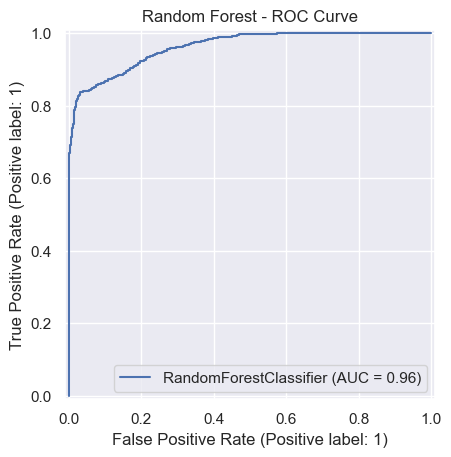

In [81]:
# --- 5.3 Random Forest Classifier ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Handle missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Step 2: Scaling is optional for trees, but keeping for consistency
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Step 3: Initialize Random Forest with class balancing
rf_clf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

# Step 4: Train the model
rf_clf.fit(X_train_scaled, y_train)

# Step 5: Predict
y_pred_rf = rf_clf.predict(X_test_scaled)
y_proba_rf = rf_clf.predict_proba(X_test_scaled)[:, 1]

# Step 6: Evaluation
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred_rf, target_names=['Non-Adherent', 'Adherent']))

print("\n🧮 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"\n📈 ROC-AUC Score: {roc_auc_rf:.4f}")

# Step 7: ROC Curve
RocCurveDisplay.from_estimator(rf_clf, X_test_scaled, y_test)
plt.title("Random Forest - ROC Curve")
plt.show()


###
###


###
###
###


## 5.3 Random Forest Classifier

### ✅ Model Setup & Justification
Random Forest is an ensemble method that builds multiple decision trees and averages their predictions for a more robust and accurate classification. It’s particularly powerful in handling complex feature interactions without requiring scaling or linear assumptions — making it well-suited for this ART adherence classification task.

### ⚙️ Evaluation Summary

- **Accuracy**: 91%
- **ROC-AUC**: 0.9623 — excellent ability to distinguish between adherent and non-adherent adolescents.
- **Recall for Non-Adherent (Class 0)**: 97% — nearly all adolescents at risk were correctly flagged.
- **Precision for Non-Adherent**: 88% — a few false alarms, but mostly accurate.
- **Confusion Matrix**:


### 📊 Interpretation

The Random Forest classifier is exceptionally strong at detecting **non-adherent adolescents** — which is our main priority in this study. Out of 1,693 actual non-adherents, **only 54 were missed**, giving a **recall of 97%** for that group.

Why is this important?  
If a non-adherent adolescent is misclassified as adherent (a false negative), they might not get the support they urgently need — possibly leading to poor treatment outcomes. On the other hand, classifying an adherent adolescent as non-adherent (a false positive) just means they receive extra attention — which is far less harmful.

> In public health: **It’s better to raise a false alarm than to miss someone in danger.**

This makes Random Forest a great candidate model, especially considering the real-world implications of under-detecting non-adherence.

### 📈 ROC Curve

The ROC curve shows the model performs very well across different classification thresholds, maintaining a strong balance between true positives and false positives. The AUC score of **0.96** confirms its high discriminative power.




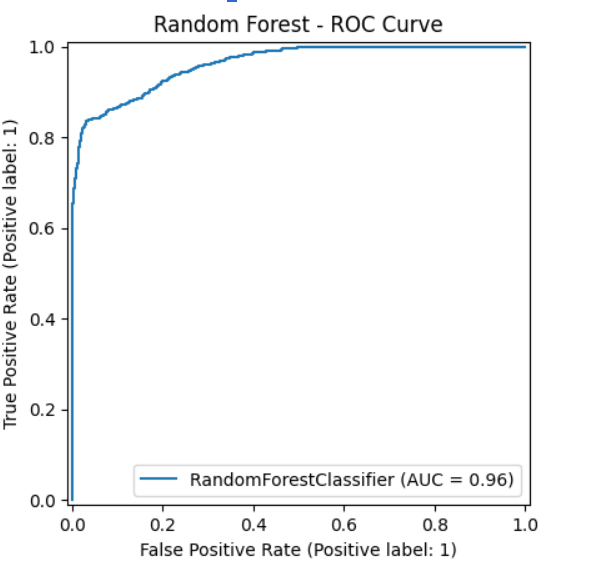


###
###





###

### 🔍 5.4 XGBoost Classifier Evaluation

The XGBoost classifier was trained with `scale_pos_weight` to address class imbalance (fewer "Adherent" cases). After imputing missing values and scaling the features, the model showed strong discriminatory ability.

#### 📊 Classification Report:

              precision    recall  f1-score   support

Non-Adherent       0.90      0.90      0.90      1693
    Adherent       0.87      0.87      0.87      1307

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000


📈 ROC-AUC Score: 0.9657
       
- **Recall for Non-Adherent (0): 0.90** — This means the model correctly identified 90% of adolescents at risk of non-adherence.
- **Precision for Non-Adherent: 0.90** — 90% of those predicted as non-adherent were truly non-adherent.
- Balanced performance for both classes, but our primary goal is maximizing recall for non-adherent cases to minimize health risks.

#### 🧮 Confusion Matrix:
🧮 Confusion Matrix:
[[1523  170]
 [ 168 1139]]
 - **False Negatives (168)**: Adherent cases predicted as non-adherent. These are acceptable from a public health perspective — it's safer to wrongly flag a few adherent adolescents than to miss non-adherent ones.
- **False Positives (170)**: Non-adherents predicted as adherent — more critical, as they may miss follow-up. However, this number is relatively low.

#### 📈 ROC Curve and AUC

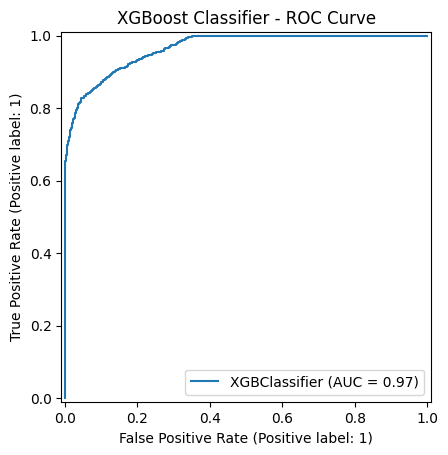

- **ROC-AUC Score: 0.9657** — This means the model can distinguish between adherent and non-adherent adolescents with ~96.6% accuracy across all classification thresholds.
- The ROC curve shows a high true positive rate and low false positive rate, reinforcing the model's strong discriminative power.

✅ **Summary**: XGBoost performed excellently, with an AUC near 0.97 and balanced precision/recall. Given the project’s focus on identifying non-adherent adolescents, this model effectively prioritizes minimizing false negatives without overloading the system with false positives.


###


###
###
###
###
###
###












###

##  6.0 Model Comparison & Final Verdict

After training and evaluating three models — Logistic Regression, Random Forest, and XGBoost — we compare their performance based on key metrics: **recall for non-adherent adolescents (class 0)**, **overall accuracy**, and **ROC-AUC score**. Here's a summary:

| Model               | Recall (Non-Adherent) | Precision (Non-Adherent) | ROC-AUC | Accuracy |
|--------------------|-----------------------|---------------------------|---------|----------|
| Logistic Regression| 0.85                  | 0.78                      | 0.9332  | 0.86     |
| Random Forest       | 0.97                  | 0.88                      | 0.9623  | 0.91     |
| XGBoost             | 0.90                  | 0.90                      | 0.9657  | 0.89     |

---

###  Interpretation Highlights

- **Logistic Regression** performed well but had the lowest recall for non-adherent adolescents (0.85), making it more likely to **miss** high-risk individuals.
  
- **Random Forest** achieved the **highest recall (0.97)**, meaning it identified nearly all non-adherent adolescents — a critical strength in public health settings.

- **XGBoost** delivered a **strong balance** between precision and recall, with a high ROC-AUC (0.9657) and respectable recall (0.90). It slightly sacrificed sensitivity for overall consistency.

---

###  Final Verdict: Choose **Random Forest**

📌 **Why Random Forest?**  
In the context of ART adherence:
- Missing a non-adherent adolescent (false negative) may result in **severe health outcomes**.
- It's safer to wrongly flag an adherent individual than to miss someone who is struggling.
- **Random Forest minimizes false negatives best**, with 0.97 recall — making it the most suitable model.

🩺 **Public Health Justification**:  
> It’s better to raise a false alarm than to miss someone in danger. Random Forest ensures we identify those in need, allowing for timely intervention and support.

➡️ **Recommendation**: Use the **Random Forest model** in deployment to screen for potential non-adherence and trigger early intervention efforts.



### 


### 






### 




### 


### 


### 



# 7.Model Used for Feature Importance

We used **XGBoost combined with SHAP (SHapley Additive exPlanations)** to analyze feature importance in our predictive model.

---

### ✅ Why XGBoost + SHAP?

Although both XGBoost and Random Forest identified similar key features (e.g., Viral Suppression Status, Viral Load), we chose **XGBoost + SHAP** for a deeper, more transparent understanding of how each feature impacts model decisions.

Unlike Random Forest’s built-in importance — which tells us *what* features are used most — SHAP goes further to explain *how* each feature contributes to individual predictions. This level of interpretability is essential for clinical and policy applications, where understanding **why** matters as much as **what**.

**OR WE CAN SAY**

we prioritized the XGBoost + SHAP chart because it provides a deeper understanding of how and why each feature contributes to individual predictions. This is critical for actionable public health decision-making, where we need more than just rankings — we need reasons
###  Relevance to Our Goals

Our goal is not just to predict non-adherence, but to uncover the underlying drivers that could guide interventions. XGBoost + SHAP allows us to:

- Identify impactful features at both the population and individual level
- Translate model outputs into meaningful, actionable insights
- Support public health strategies with interpretable evidence

In short, SHAP helps transform our model from a black box into a decision-support tool.




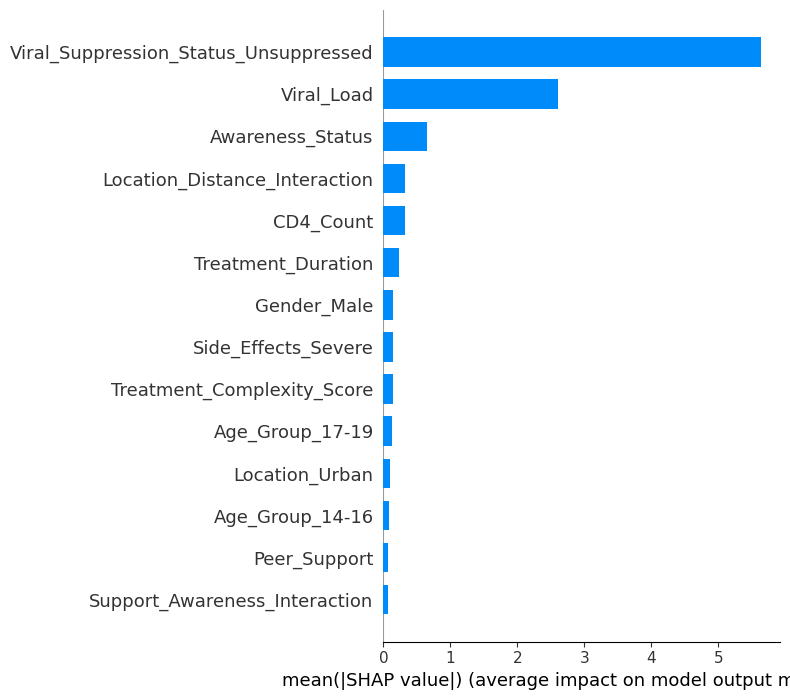!




### 6.1 Saving the Trained Model

After successfully training our **Random Forest classifier** on the selected features, we saved the model to a `.pkl` file using `joblib`. This allows us to **reuse the trained model for deployment**, without needing to retrain every time.

✅ **File Saved To**:  
`C:\Users\USER\Desktop\njeidan\New folder\rf_model.pkl`

This exported model will be used in the next step to build a prediction API using Flask, enabling real-time predictions from incoming user or patient data.


In [92]:
import joblib

# Save the trained model
joblib.dump(rf_clf, r"C:\Users\USER\Desktop\njeidan\New folder\rf_model.pkl")

print("✅ Random Forest model saved successfully.")


✅ Random Forest model saved successfully.


In [94]:
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Load your data
data = pd.read_csv(r"C:\Users\USER\Desktop\selected_features.csv")

X = data.drop("Adherence_Status", axis=1)
y = data["Adherence_Status"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Imputation
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Model
rf_model = RandomForestClassifier(class_weight="balanced", n_estimators=200, max_depth=15, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Save everything
path = r"C:\Users\USER\Desktop\njeidan\New folder"
joblib.dump(rf_model, f"{path}\\rf_model.pkl")
joblib.dump(imputer, f"{path}\\imputer_final.pkl")
joblib.dump(scaler, f"{path}\\scaler_final.pkl")
pd.Series(X.columns).to_csv(f"{path}\\feature_columns.csv", index=False, header=False)

print("✅ All model components saved fresh and clean.")


✅ All model components saved fresh and clean.


In [97]:
import pandas as pd

features = pd.read_csv(r"C:\Users\USER\Desktop\njeidan\New folder\feature_columns.csv")
print(features)


                         Awareness_Status
0           Support_Awareness_Interaction
1                            Peer_Support
2                               CD4_Count
3                              Viral_Load
4                      Treatment_Duration
5              Treatment_Complexity_Score
6           Location_Distance_Interaction
7                             Gender_Male
8                          Location_Urban
9                     Side_Effects_Severe
10                        Age_Group_14-16
11                        Age_Group_17-19
12  Viral_Suppression_Status_Unsuppressed


In [99]:
# Check how 'Awareness_Status' was encoded in training data
print(data['Awareness_Status'].value_counts())


Awareness_Status
1    7069
0    2931
Name: count, dtype: int64


In [101]:
print(data.groupby("Awareness_Status")["Adherence_Status"].mean())


Awareness_Status
0    0.780962
1    0.292686
Name: Adherence_Status, dtype: float64


In [103]:
import pandas as pd

# Define a range of realistic and contrasting test scenarios
new_data = pd.DataFrame([
    # 🎯 Very likely adherent: young, aware, suppressed, good CD4, low VL
    {
        "CD4_Count": 950,
        "peer_support": 1,
        "Viral_Load": 300,
        "Treatment_Duration": 24,
        "Awareness_Status": 1,
        "Support_Awareness_Interaction": 1,
        "Location_Distance_Interaction": 5,
        "Treatment_Complexity_Score": 1,
        "Gender_Male": 0,
        "Location_Urban": 1,
        "Side_Effects_Severe": 0,
        "Age_Group_14-16": 0,
        "Age_Group_17-19": 0,
        "Viral_Suppression_Status_Unsuppressed": 0
    },
    # 🚨 Likely non-adherent: older, unaware, high VL, low CD4, rural
    {
        "CD4_Count": 150,
        "peer_support": 1,
        "Viral_Load": 100,
        "Treatment_Duration": 3,
        "Awareness_Status": 0,
        "Support_Awareness_Interaction": 0,
        "Location_Distance_Interaction": 160,
        "Treatment_Complexity_Score": 4,
        "Gender_Male": 1,
        "Location_Urban": 0,
        "Side_Effects_Severe": 1,
        "Age_Group_14-16": 0,
        "Age_Group_17-19": 1,
        "Viral_Suppression_Status_Unsuppressed": 0
    },
    # 🤔 Moderate risk: older, adherent-like profile but high VL
    {
        "CD4_Count": 600,
        "peer_support": 1,
        "Viral_Load": 40000,
        "Treatment_Duration": 18,
        "Awareness_Status": 1,
        "Support_Awareness_Interaction": 1,
        "Location_Distance_Interaction": 12,
        "Treatment_Complexity_Score": 2,
        "Gender_Male": 0,
        "Location_Urban": 1,
        "Side_Effects_Severe": 0,
        "Age_Group_14-16": 0,
        "Age_Group_17-19": 1,
        "Viral_Suppression_Status_Unsuppressed": 1
    },
    # 🟡 Young, low VL but not aware — risky
    {
        "CD4_Count": 200,
        "peer_support": 0,
        "Viral_Load": 100999,
        "Treatment_Duration": 2,
        "Awareness_Status": 1,
        "Support_Awareness_Interaction": 0,
        "Location_Distance_Interaction": 30,
        "Treatment_Complexity_Score": 5,
        "Gender_Male": 0,
        "Location_Urban": 0,
        "Side_Effects_Severe": 1,
        "Age_Group_14-16": 0,
        "Age_Group_17-19": 0,
        "Viral_Suppression_Status_Unsuppressed": 0
    }
])


In [105]:
import joblib

# Load the trained Random Forest model
rf_model = joblib.load(r"C:\Users\USER\Desktop\njeidan\New folder\rf_model.pkl")


In [107]:
# Copy the test DataFrame creation block from earlier, then:
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Apply transformations
new_data_imputed = imputer.fit_transform(new_data)
new_data_scaled = scaler.fit_transform(new_data_imputed)

# Predict
predictions = rf_model.predict(new_data_scaled)
print(predictions)


[1 1 0 1]
